In [1]:
import os
import keras
import mne
import numpy as np
import pandas as pd
import scipy.io
import tensorflow as tf
from mne.channels import make_standard_montage
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


In [2]:
data_dir = os.path.dirname("./data/")
data_files = os.listdir(data_dir)

In [3]:
def annotations_from_eGUI(raw, egui):
    codes = []
    starts = []

    current_state = None

    for i in range(len(egui)):
        if egui[i][0] != current_state:
            starts.append(i)
            current_state = egui[i][0]
            codes.append(str(egui[i][0]))

    starts.append(len(egui))
    codes = np.array(codes)
    sf = raw.info.get('sfreq')
    starts = np.array(starts) / sf
    durations = starts[1:] - starts[:-1]
    starts = starts[:-1]

    raw.set_annotations(mne.Annotations(onset=starts, duration=durations, description=codes))


def raw_from_mat(file):
    mat = scipy.io.loadmat(os.path.join(data_dir, file))

    sampling_freq = mat["o"][0][0][2][0][0]
    n_samples = mat["o"][0][0][3][0][0]
    ch_names = [element[0][0] for element in mat["o"][0][0][6]]

    df = pd.DataFrame(mat["o"][0][0][5], columns=ch_names)
    df = df.drop(columns=["X5"])
    df = df.T
    ch_names.remove("X5")

    ch_types = ['eeg'] * 21
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
    raw = mne.io.RawArray(df.to_numpy(), info)

    montage = make_standard_montage("standard_prefixed")
    raw.set_montage(montage)

    raw.load_data().set_eeg_reference(ref_channels='average')
    annotations_from_eGUI(raw, mat["o"][0][0][4])
    return raw


def filter_raw(raw):
    return raw.load_data().filter(0.1, 30, method="fir", phase="zero-double")

In [7]:
raw_NoMT = [raw_from_mat(file) for file in data_files if "NoMT" in file]
raw_FREEFORM = [raw_from_mat(file) for file in data_files if "FREEFORM" in file]

Creating RawArray with float64 data, n_channels=21, n_times=664400
    Range : 0 ... 664399 =      0.000 ...  3321.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=21, n_times=664600
    Range : 0 ... 664599 =      0.000 ...  3322.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=21, n_times=662400
    Range : 0 ... 662399 =      0.000 ...  3311.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=21, n_times=667600
    Range : 0 ... 667599 =      0.000 ...  3337.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 d

In [4]:
mne.events_from_annotations(raw_FREEFORM[0])

NameError: name 'raw_FREEFORM' is not defined

In [8]:
def get_epochs(raw,event_id):
    metadata_tmin, metadata_tmax = -1, 1
    event_id=event_id
    all_events, all_event_id = mne.events_from_annotations(raw,event_id=event_id)
    metadata, events, event_id = mne.epochs.make_metadata(
        events=all_events,
        event_id=event_id,
        tmin=metadata_tmin,
        tmax=metadata_tmax,
        sfreq=raw.info["sfreq"],
    )
    print(raw.info["sfreq"])
    return mne.Epochs(raw, events, event_id)


We will create now several Datasets where we will test our methods on.

 - `epochs_NoMT` will correspond to the data which is our baseline and where the subject is in a resting position whith no input on the screen. ( only take events "0")
 - `epochs_NOMT_only_code_2` will correspond to the data which comes from the same trails and session of the epochs_NoMT data but we select here epochs where there is a    shown on the screen. (only take events "2")
 - `epochs_FREEFORM` will correspond to the data which comes from a diffrent session and here the subject can voluntarily  press buttons (either left or right)

In [9]:
epochs_NoMT = [get_epochs(file,{"0":1}) for file in raw_NoMT]
epochs_FREEFORM = [get_epochs(file,{'1': 2, '2': 3}) for file in raw_FREEFORM]
epochs_NOMT_only_code_2=[get_epochs(file,{"2":3}) for file in raw_NoMT]

Used Annotations descriptions: ['0']
200.0
Not setting metadata
966 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
960 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
963 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
968 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
968 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)

In [8]:
print

<function print>

In [10]:
print(epochs_NoMT[0].get_data().max())
print(epochs_NOMT_only_code_2[0].get_data().max())

Using data from preloaded Raw for 966 events and 141 original time points ...
1 bad epochs dropped
865.3172938443672
Using data from preloaded Raw for 159 events and 141 original time points ...
0 bad epochs dropped
161.4782694541231


In [11]:
epochs_FREEFORM[0].get_data().max()

Using data from preloaded Raw for 739 events and 141 original time points ...
0 bad epochs dropped


83.5072706155633

In [12]:
epochs_data_NOMT = [file.get_data() for file in epochs_NoMT]
epochs_data_FREEFORM = [file.get_data() for file in epochs_FREEFORM]
epochs_Data_NOMT_2 =[file.get_data() for file in epochs_NOMT_only_code_2]

Using data from preloaded Raw for 965 events and 141 original time points ...
Using data from preloaded Raw for 960 events and 141 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 963 events and 141 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 968 events and 141 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 968 events and 141 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 968 events and 141 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 967 events and 141 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 739 events and 141 original time points ...
Using data from preloaded Raw for 688 events and 141 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 700 events and 141 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 159 events and 141

In [13]:
stacked_NOMT = np.vstack(epochs_data_NOMT)
stacked_FREEFORM = np.vstack(epochs_data_FREEFORM)
stacked_NOMT_2 = np.vstack(epochs_Data_NOMT_2)

In [14]:
print(stacked_NOMT.shape)
print(stacked_FREEFORM.shape)
print(stacked_NOMT_2.shape)

(6753, 21, 141)
(2127, 21, 141)
(1114, 21, 141)


looking at the scaling of this datasets : 

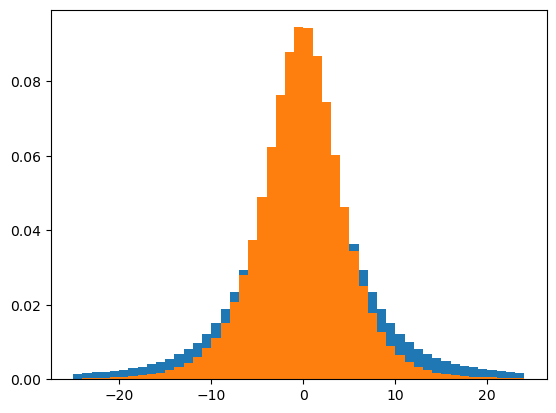

In [15]:
import matplotlib.pyplot as plt
plt.hist(stacked_NOMT.reshape(-1), bins=np.arange(-25,25),density=True)
plt.hist(stacked_FREEFORM.reshape(-1), bins=np.arange(-25,25),density=True)
#plt.hist(stacked_NOMT_2.reshape(-1), bins=np.arange(-25,25),density=True)
plt.show()

In [16]:
np.random.shuffle(stacked_NOMT)
np.random.shuffle(stacked_FREEFORM)
np.random.shuffle(stacked_NOMT_2)

In [17]:
N=stacked_NOMT.shape[0]
X_nomt_train = stacked_NOMT[:5000]
X_nomt_test = stacked_NOMT[5000:]

In [18]:
X_free=stacked_FREEFORM

In [19]:
X_nomt_2 = stacked_NOMT_2

In [20]:
X_nomt_2.shape

(1114, 21, 141)

In [21]:
stacked_FREEFORM.shape

(2127, 21, 141)

In [22]:
print(X_nomt_train.shape)
print(X_nomt_test.shape)
print(X_free.shape)
print(X_nomt_2.shape)

(5000, 21, 141)
(1753, 21, 141)
(2127, 21, 141)
(1114, 21, 141)


In [23]:
mse = tf.keras.losses.MeanSquaredError()

In [24]:
mse(X_nomt_train,0).numpy()

195

In [25]:
mse(X_nomt_test,0).numpy()

222

In [26]:
mse(X_free,0).numpy()

37

In [27]:
mse(X_nomt_2,0).numpy()

188

In [28]:
print("Max: ")
print(np.max(X_nomt_train))
print(np.max(X_nomt_test))
print(np.max(X_free))
print(np.max(X_nomt_2))
print("MIn: ")
print(np.min(X_nomt_train))
print(np.min(X_nomt_test))
print(np.min(X_free))
print(np.min(X_nomt_2))

Max: 
747.3898838559813
865.3172938443672
153.28042973286878
458.65152148664345
MIn: 
-563.1676306620207
-522.8374680603947
-145.61401858304296
-422.36721254355405


create scaled versions of datasets

In [29]:
norm_stacked_NOMT = layers.Normalization()
norm_X_free = layers.Normalization()
norm_X_nomt_2=layers.Normalization()

In [30]:
norm_stacked_NOMT.adapt(stacked_NOMT.astype(float))
norm_X_free.adapt(X_free.astype(float))
norm_X_nomt_2.adapt(X_nomt_2.astype(float))

In [31]:
scaled_X_nomt_train=norm_stacked_NOMT(X_nomt_train)
scaled_X_nomt_test=norm_stacked_NOMT(X_nomt_test)
scaled_X_free=norm_X_free(X_free)
scaled_X_nomt_2=norm_X_nomt_2(X_nomt_2)

In [32]:
print(mse(scaled_X_nomt_train,0).numpy())
print(mse(scaled_X_nomt_test,0).numpy())
print(mse(scaled_X_free,0).numpy())
print(mse(scaled_X_nomt_2,0).numpy())

0
0
0
0


In [33]:
print("Max: ")
print(np.max(scaled_X_nomt_train))
print(np.max(scaled_X_nomt_test))
print(np.max(scaled_X_free))
print(np.max(scaled_X_nomt_2))
print("MIn: ")
print(np.min(scaled_X_nomt_train))
print(np.min(scaled_X_nomt_test))
print(np.min(scaled_X_free))
print(np.min(scaled_X_nomt_2))

Max: 
49.150326
102.11555
29.62884
32.611275
MIn: 
-48.57784
-80.36803
-38.27707
-31.504633


In [33]:
"""
layer = layers.Normalization()
layer1 = layers.Normalization()
layer.adapt(X_nomt_train.astype(float))
layer1.adapt(X_free_test.astype(float))

print(X_nomt_train)
print(np.max(X_nomt_train))
print(np.max(X_free_test))
print(np.max(layer(X_nomt_train)))
print(np.max(layer1(X_free_test)))
"""

'\nlayer = layers.Normalization()\nlayer1 = layers.Normalization()\nlayer.adapt(X_nomt_train.astype(float))\nlayer1.adapt(X_free_test.astype(float))\n\nprint(X_nomt_train)\nprint(np.max(X_nomt_train))\nprint(np.max(X_free_test))\nprint(np.max(layer(X_nomt_train)))\nprint(np.max(layer1(X_free_test)))\n'

# Autoencoder

In [134]:
keras.backend.clear_session()

## small model

In [36]:
class Autoencoder_small(Model):
    def __init__(self):
        super(Autoencoder_small, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(64, activation='gelu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(21 * 141, activation='linear'),
            layers.Reshape((21, 141))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder_small = Autoencoder_small()
autoencoder_small_scaled = Autoencoder_small()

In [89]:
class Autoencoder_small_dropout(Model):
    def __init__(self):
        super(Autoencoder_small_dropout, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(64, activation='gelu'),
            
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(21 * 141, activation='linear'),
            layers.Dropout(0.5),
            layers.Reshape((21, 141))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder_small_dropout = Autoencoder_small_dropout()
autoencoder_small_scaled_dropout = Autoencoder_small_dropout()

# medium model

In [133]:
class Autoencoder_medium(Model):
    def __init__(self):
        super(Autoencoder_medium, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(1024, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(128, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1024, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(21 * 141, activation='linear'),
            layers.Reshape((21, 141))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder_medium = Autoencoder_medium()
autoencoder_medium_Scaled = Autoencoder_medium()

## large model

In [39]:
class Autoencoder_large(Model):
    def __init__(self):
        super(Autoencoder_large, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dropout(0.3),
            layers.Dense(4128, activation='gelu'),
            layers.Dropout(0.1),
            layers.Dense(1024, activation='gelu'),
            layers.Dense(1024, activation='gelu'),
            layers.Dense(512, activation='gelu'),
            layers.Dense(64, activation='gelu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(512, activation='gelu'),
            layers.Dense(1024, activation='gelu'),
            layers.Dense(1024, activation='gelu'),
            layers.Dense(4128, activation='gelu'),
            layers.Dense(21 * 141, activation='linear'),
            layers.Reshape((21, 141))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder_large = Autoencoder_large()
autoencoder_large_Scaled = Autoencoder_large()

In [40]:
opt_e3 = keras.optimizers.Adam(learning_rate=1e-03)
opt_e4 = keras.optimizers.Adam(learning_rate=2e-05)
opt_e5 = keras.optimizers.Adam(learning_rate=1e-05)
opt_e6 = keras.optimizers.Adam(learning_rate=1e-06)
loss=losses.MeanSquaredError()
opti=[opt_e4,opt_e5]
epochs=[50,100,300]
bs=[128,512]

In [41]:
initial_learning_rate = 1e-04
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=30,
    decay_rate=0.97,
    staircase=True)

autoencoder_small.compile(optimizer=opt_e4, loss=loss)
autoencoder_small_scaled.compile(optimizer=opt_e4, loss=loss)
autoencoder_medium.compile(optimizer=opt_e4, loss=loss)
autoencoder_medium_Scaled.compile(optimizer=opt_e4, loss=loss)
autoencoder_large.compile(optimizer=opt_e4, loss=loss)
autoencoder_large_Scaled.compile(optimizer=opt_e4, loss=loss)
autoencoder_small_dropout.compile(optimizer=opt_e4, loss=loss)
autoencoder_medium_Scaled = Autoencoder_medium()


In [42]:
opt_e4.learning_rate.numpy()


2e-05

In [43]:
def train_model(ae,X_train,X_test,Y,lr,epochs,bs):
    hist=ae.fit(X_train, X_train,
                epochs=epochs,
                batch_size=bs,
                shuffle=True,
                validation_data=(X_test, X_test))
    
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return (hist.history["loss"],hist.history["val_loss"],lr.learning_rate.numpy(),epochs,bs)
    
    
    
    

Epoch 1/500
20/20 [==============================] - 0s 8ms/step - loss: 30.3970 - val_loss: 34.7093
Epoch 2/500
20/20 [==============================] - 0s 8ms/step - loss: 30.3905 - val_loss: 34.7061
Epoch 3/500
20/20 [==============================] - 0s 8ms/step - loss: 30.3671 - val_loss: 34.7043
Epoch 4/500
20/20 [==============================] - 0s 8ms/step - loss: 30.3024 - val_loss: 34.6937
Epoch 5/500
20/20 [==============================] - 0s 7ms/step - loss: 30.3310 - val_loss: 34.6863
Epoch 6/500
20/20 [==============================] - 0s 8ms/step - loss: 30.3246 - val_loss: 34.6856
Epoch 7/500
20/20 [==============================] - 0s 8ms/step - loss: 30.2739 - val_loss: 34.6844
Epoch 8/500
20/20 [==============================] - 0s 8ms/step - loss: 30.3969 - val_loss: 34.6927
Epoch 9/500
20/20 [==============================] - 0s 8ms/step - loss: 30.3522 - val_loss: 34.6882
Epoch 10/500
20/20 [==============================] - 0s 8ms/step - loss: 30.3638 - val_los

20/20 [==============================] - 0s 9ms/step - loss: 30.1959 - val_loss: 34.6069
Epoch 161/500
20/20 [==============================] - 0s 9ms/step - loss: 30.2287 - val_loss: 34.5972
Epoch 162/500
20/20 [==============================] - 0s 9ms/step - loss: 30.2537 - val_loss: 34.5955
Epoch 163/500
20/20 [==============================] - 0s 9ms/step - loss: 30.2772 - val_loss: 34.6054
Epoch 164/500
20/20 [==============================] - 0s 10ms/step - loss: 30.2241 - val_loss: 34.6003
Epoch 165/500
20/20 [==============================] - 0s 10ms/step - loss: 30.2436 - val_loss: 34.6112
Epoch 166/500
20/20 [==============================] - 0s 9ms/step - loss: 30.2478 - val_loss: 34.6036
Epoch 167/500
20/20 [==============================] - 0s 9ms/step - loss: 30.2458 - val_loss: 34.6165
Epoch 168/500
20/20 [==============================] - 0s 9ms/step - loss: 30.2522 - val_loss: 34.6030
Epoch 169/500
20/20 [==============================] - 0s 9ms/step - loss: 30.2949 - 

20/20 [==============================] - 0s 9ms/step - loss: 30.1834 - val_loss: 34.4704
Epoch 319/500
20/20 [==============================] - 0s 9ms/step - loss: 30.2163 - val_loss: 34.4750
Epoch 320/500
20/20 [==============================] - 0s 10ms/step - loss: 30.1130 - val_loss: 34.4930
Epoch 321/500
20/20 [==============================] - 0s 9ms/step - loss: 30.1457 - val_loss: 34.4726
Epoch 322/500
20/20 [==============================] - 0s 9ms/step - loss: 30.1993 - val_loss: 34.4744
Epoch 323/500
20/20 [==============================] - 0s 9ms/step - loss: 30.0725 - val_loss: 34.4750
Epoch 324/500
20/20 [==============================] - 0s 9ms/step - loss: 30.2405 - val_loss: 34.4848
Epoch 325/500
20/20 [==============================] - 0s 9ms/step - loss: 30.1403 - val_loss: 34.4800
Epoch 326/500
20/20 [==============================] - 0s 9ms/step - loss: 30.1805 - val_loss: 34.4746
Epoch 327/500
20/20 [==============================] - 0s 10ms/step - loss: 30.1586 - 

20/20 [==============================] - 0s 10ms/step - loss: 30.0538 - val_loss: 34.3997
Epoch 477/500
20/20 [==============================] - 0s 9ms/step - loss: 30.1706 - val_loss: 34.3974
Epoch 478/500
20/20 [==============================] - 0s 9ms/step - loss: 30.1271 - val_loss: 34.3917
Epoch 479/500
20/20 [==============================] - 0s 9ms/step - loss: 30.1074 - val_loss: 34.3923
Epoch 480/500
20/20 [==============================] - 0s 9ms/step - loss: 30.0977 - val_loss: 34.4037
Epoch 481/500
20/20 [==============================] - 0s 11ms/step - loss: 30.0412 - val_loss: 34.3956
Epoch 482/500
20/20 [==============================] - 0s 10ms/step - loss: 30.1032 - val_loss: 34.3859
Epoch 483/500
20/20 [==============================] - 0s 9ms/step - loss: 30.0586 - val_loss: 34.3969
Epoch 484/500
20/20 [==============================] - 0s 9ms/step - loss: 30.0091 - val_loss: 34.4089
Epoch 485/500
20/20 [==============================] - 0s 9ms/step - loss: 30.1047 -

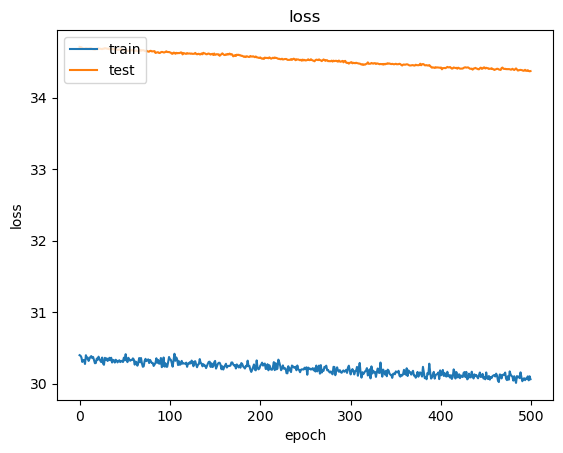

([30.39704132080078,
  30.390533447265625,
  30.367137908935547,
  30.30240249633789,
  30.33103370666504,
  30.324644088745117,
  30.27385902404785,
  30.396886825561523,
  30.35224723815918,
  30.363847732543945,
  30.316791534423828,
  30.347919464111328,
  30.374055862426758,
  30.384658813476562,
  30.35706329345703,
  30.37151336669922,
  30.328746795654297,
  30.28431510925293,
  30.288253784179688,
  30.349708557128906,
  30.330493927001953,
  30.376506805419922,
  30.34471321105957,
  30.31900405883789,
  30.29998207092285,
  30.364234924316406,
  30.279233932495117,
  30.262638092041016,
  30.36050033569336,
  30.331594467163086,
  30.352928161621094,
  30.316308975219727,
  30.330646514892578,
  30.36079978942871,
  30.325471878051758,
  30.361347198486328,
  30.29451560974121,
  30.331987380981445,
  30.32413101196289,
  30.29386329650879,
  30.33319664001465,
  30.321231842041016,
  30.29644775390625,
  30.314105987548828,
  30.326234817504883,
  30.299997329711914,
  30.3

In [154]:
train_model(autoencoder_small_dropout,X_nomt_train,X_nomt_test,_,opt_e6,500,256)

In [66]:
print(tm)

[27.875185012817383, 27.843097686767578, 27.83732795715332, 27.82332420349121, 27.84373664855957, 27.842187881469727, 27.83306312561035, 27.826190948486328, 27.823108673095703, 27.835390090942383]


## Not scaled : 

### small

Epoch 1/50
40/40 [==============================] - 1s 13ms/step - loss: 199.1449 - val_loss: 219.0786
Epoch 2/50
40/40 [==============================] - 0s 5ms/step - loss: 168.3046 - val_loss: 168.3704
Epoch 3/50
40/40 [==============================] - 0s 5ms/step - loss: 133.6914 - val_loss: 136.9304
Epoch 4/50
40/40 [==============================] - 0s 5ms/step - loss: 117.1717 - val_loss: 124.8530
Epoch 5/50
40/40 [==============================] - 0s 5ms/step - loss: 108.3691 - val_loss: 116.5535
Epoch 6/50
40/40 [==============================] - 0s 5ms/step - loss: 101.9889 - val_loss: 110.0745
Epoch 7/50
40/40 [==============================] - 0s 5ms/step - loss: 95.9251 - val_loss: 103.9721
Epoch 8/50
40/40 [==============================] - 0s 5ms/step - loss: 91.2207 - val_loss: 98.9117
Epoch 9/50
40/40 [==============================] - 0s 5ms/step - loss: 87.2053 - val_loss: 94.9660
Epoch 10/50
40/40 [==============================] - 0s 6ms/step - loss: 83.7258 - val

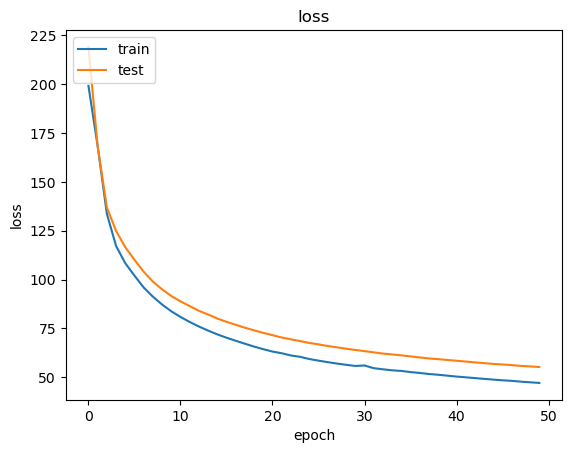

Epoch 1/100
40/40 [==============================] - 1s 27ms/step - loss: 164.3381 - val_loss: 129.3188
Epoch 2/100
40/40 [==============================] - 0s 6ms/step - loss: 103.0796 - val_loss: 98.9757
Epoch 3/100
40/40 [==============================] - 0s 5ms/step - loss: 82.4980 - val_loss: 83.9557
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 72.1714 - val_loss: 76.4703
Epoch 5/100
40/40 [==============================] - 0s 6ms/step - loss: 66.2199 - val_loss: 71.6861
Epoch 6/100
40/40 [==============================] - 0s 6ms/step - loss: 62.7662 - val_loss: 68.4142
Epoch 7/100
40/40 [==============================] - 0s 5ms/step - loss: 59.7646 - val_loss: 66.0907
Epoch 8/100
40/40 [==============================] - 0s 5ms/step - loss: 57.8086 - val_loss: 64.3314
Epoch 9/100
40/40 [==============================] - 0s 5ms/step - loss: 56.5539 - val_loss: 62.9298
Epoch 10/100
40/40 [==============================] - 0s 5ms/step - loss: 54.9721 - val

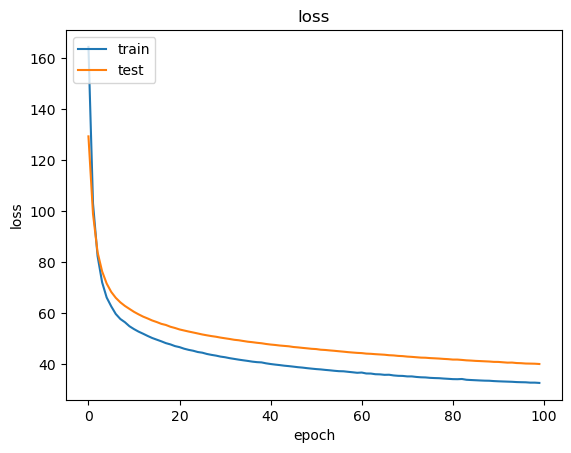

Epoch 1/300
40/40 [==============================] - 1s 9ms/step - loss: 157.9381 - val_loss: 127.0207
Epoch 2/300
40/40 [==============================] - 0s 10ms/step - loss: 100.2900 - val_loss: 98.6453
Epoch 3/300
40/40 [==============================] - 0s 5ms/step - loss: 81.0981 - val_loss: 84.5006
Epoch 4/300
40/40 [==============================] - 0s 5ms/step - loss: 70.9680 - val_loss: 76.2962
Epoch 5/300
40/40 [==============================] - 0s 5ms/step - loss: 65.3931 - val_loss: 71.9752
Epoch 6/300
40/40 [==============================] - 0s 5ms/step - loss: 61.6528 - val_loss: 68.6980
Epoch 7/300
40/40 [==============================] - 0s 5ms/step - loss: 59.0075 - val_loss: 66.3630
Epoch 8/300
40/40 [==============================] - 0s 5ms/step - loss: 57.0014 - val_loss: 64.5739
Epoch 9/300
40/40 [==============================] - 0s 5ms/step - loss: 55.4537 - val_loss: 62.7280
Epoch 10/300
40/40 [==============================] - 0s 5ms/step - loss: 54.1009 - val

Epoch 161/300
40/40 [==============================] - 0s 5ms/step - loss: 30.2445 - val_loss: 37.9724
Epoch 162/300
40/40 [==============================] - 0s 5ms/step - loss: 30.2394 - val_loss: 37.9678
Epoch 163/300
40/40 [==============================] - 0s 5ms/step - loss: 30.1860 - val_loss: 37.9551
Epoch 164/300
40/40 [==============================] - 0s 5ms/step - loss: 30.1728 - val_loss: 37.9697
Epoch 165/300
40/40 [==============================] - 0s 5ms/step - loss: 30.1507 - val_loss: 37.8794
Epoch 166/300
40/40 [==============================] - 0s 5ms/step - loss: 30.1657 - val_loss: 37.8973
Epoch 167/300
40/40 [==============================] - 0s 5ms/step - loss: 30.1749 - val_loss: 37.8719
Epoch 168/300
40/40 [==============================] - 0s 5ms/step - loss: 30.1678 - val_loss: 37.8483
Epoch 169/300
40/40 [==============================] - 0s 5ms/step - loss: 30.0416 - val_loss: 37.7993
Epoch 170/300
40/40 [==============================] - 0s 5ms/step - loss

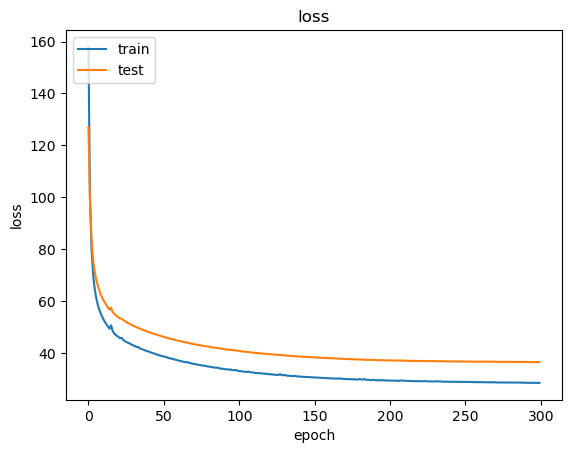

Epoch 1/50
10/10 [==============================] - 1s 23ms/step - loss: 197.6302 - val_loss: 206.4212
Epoch 2/50
10/10 [==============================] - 0s 12ms/step - loss: 156.6684 - val_loss: 150.0773
Epoch 3/50
10/10 [==============================] - 0s 10ms/step - loss: 123.5328 - val_loss: 127.2416
Epoch 4/50
10/10 [==============================] - 0s 11ms/step - loss: 108.0743 - val_loss: 113.2814
Epoch 5/50
10/10 [==============================] - 0s 11ms/step - loss: 97.0793 - val_loss: 103.1639
Epoch 6/50
10/10 [==============================] - 0s 11ms/step - loss: 88.7994 - val_loss: 95.3007
Epoch 7/50
10/10 [==============================] - 0s 11ms/step - loss: 82.2336 - val_loss: 89.2824
Epoch 8/50
10/10 [==============================] - 0s 13ms/step - loss: 77.2586 - val_loss: 84.3789
Epoch 9/50
10/10 [==============================] - 0s 14ms/step - loss: 73.1349 - val_loss: 80.6070
Epoch 10/50
10/10 [==============================] - 0s 13ms/step - loss: 69.9726 

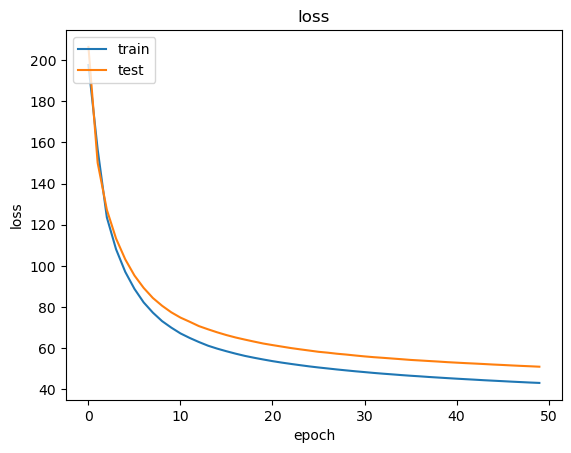

Epoch 1/100
10/10 [==============================] - 1s 26ms/step - loss: 200.7610 - val_loss: 214.5339
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 163.3330 - val_loss: 155.7909
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 125.3301 - val_loss: 126.2024
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 106.5850 - val_loss: 110.6219
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 94.2061 - val_loss: 100.2792
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 85.7292 - val_loss: 92.5841
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 79.6284 - val_loss: 86.6358
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 74.8434 - val_loss: 82.1384
Epoch 9/100
10/10 [==============================] - 0s 14ms/step - loss: 71.0164 - val_loss: 78.5012
Epoch 10/100
10/10 [==============================] - 0s 13ms/step - loss

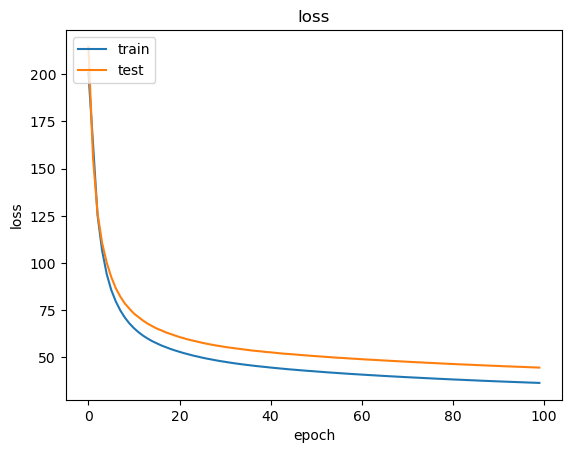

Epoch 1/300
10/10 [==============================] - 1s 24ms/step - loss: 197.8597 - val_loss: 206.3179
Epoch 2/300
10/10 [==============================] - 0s 11ms/step - loss: 156.0975 - val_loss: 150.4760
Epoch 3/300
10/10 [==============================] - 0s 12ms/step - loss: 123.9548 - val_loss: 127.2567
Epoch 4/300
10/10 [==============================] - 0s 11ms/step - loss: 108.2561 - val_loss: 113.3719
Epoch 5/300
10/10 [==============================] - 0s 12ms/step - loss: 97.0103 - val_loss: 103.5227
Epoch 6/300
10/10 [==============================] - 0s 12ms/step - loss: 88.4703 - val_loss: 95.2226
Epoch 7/300
10/10 [==============================] - 0s 12ms/step - loss: 81.6492 - val_loss: 88.5236
Epoch 8/300
10/10 [==============================] - 0s 11ms/step - loss: 76.1571 - val_loss: 83.1821
Epoch 9/300
10/10 [==============================] - 0s 12ms/step - loss: 71.8517 - val_loss: 79.0361
Epoch 10/300
10/10 [==============================] - 0s 14ms/step - loss

10/10 [==============================] - 0s 12ms/step - loss: 32.9846 - val_loss: 40.8938
Epoch 160/300
10/10 [==============================] - 0s 13ms/step - loss: 32.9360 - val_loss: 40.8641
Epoch 161/300
10/10 [==============================] - 0s 13ms/step - loss: 32.8933 - val_loss: 40.8343
Epoch 162/300
10/10 [==============================] - 0s 14ms/step - loss: 32.8473 - val_loss: 40.7570
Epoch 163/300
10/10 [==============================] - 0s 12ms/step - loss: 32.8134 - val_loss: 40.7300
Epoch 164/300
10/10 [==============================] - 0s 12ms/step - loss: 32.7704 - val_loss: 40.6853
Epoch 165/300
10/10 [==============================] - 0s 12ms/step - loss: 32.7325 - val_loss: 40.6582
Epoch 166/300
10/10 [==============================] - 0s 12ms/step - loss: 32.6870 - val_loss: 40.5769
Epoch 167/300
10/10 [==============================] - 0s 12ms/step - loss: 32.6507 - val_loss: 40.5370
Epoch 168/300
10/10 [==============================] - 0s 12ms/step - loss: 32

Epoch 238/300
10/10 [==============================] - 0s 11ms/step - loss: 30.6230 - val_loss: 38.2756
Epoch 239/300
10/10 [==============================] - 0s 11ms/step - loss: 30.5947 - val_loss: 38.2574
Epoch 240/300
10/10 [==============================] - 0s 11ms/step - loss: 30.5818 - val_loss: 38.2299
Epoch 241/300
10/10 [==============================] - 0s 12ms/step - loss: 30.5587 - val_loss: 38.2308
Epoch 242/300
10/10 [==============================] - 0s 11ms/step - loss: 30.5416 - val_loss: 38.2034
Epoch 243/300
10/10 [==============================] - 0s 11ms/step - loss: 30.5230 - val_loss: 38.1698
Epoch 244/300
10/10 [==============================] - 0s 12ms/step - loss: 30.4974 - val_loss: 38.1609
Epoch 245/300
10/10 [==============================] - 0s 13ms/step - loss: 30.4805 - val_loss: 38.1266
Epoch 246/300
10/10 [==============================] - 0s 13ms/step - loss: 30.4620 - val_loss: 38.1036
Epoch 247/300
10/10 [==============================] - 0s 11ms/s

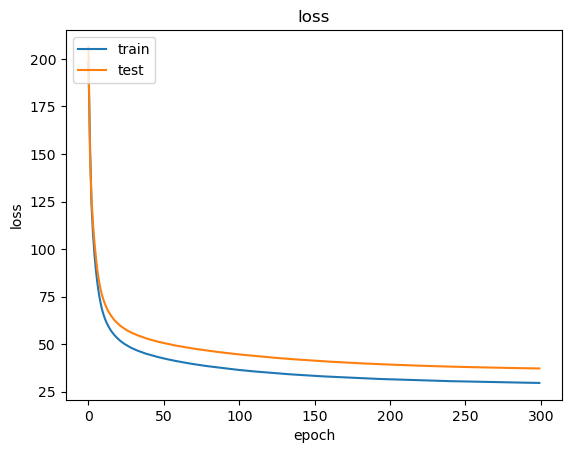

Epoch 1/50
40/40 [==============================] - 1s 9ms/step - loss: 209.0049 - val_loss: 244.7020
Epoch 2/50
40/40 [==============================] - 0s 6ms/step - loss: 208.6281 - val_loss: 244.2581
Epoch 3/50
40/40 [==============================] - 0s 6ms/step - loss: 208.2752 - val_loss: 243.8384
Epoch 4/50
40/40 [==============================] - 0s 6ms/step - loss: 207.9359 - val_loss: 243.4337
Epoch 5/50
40/40 [==============================] - 0s 6ms/step - loss: 207.6094 - val_loss: 243.0455
Epoch 6/50
40/40 [==============================] - 0s 6ms/step - loss: 207.3001 - val_loss: 242.6706
Epoch 7/50
40/40 [==============================] - 0s 6ms/step - loss: 207.0035 - val_loss: 242.3170
Epoch 8/50
40/40 [==============================] - 0s 6ms/step - loss: 206.7095 - val_loss: 241.9722
Epoch 9/50
40/40 [==============================] - 0s 6ms/step - loss: 206.4432 - val_loss: 241.6544
Epoch 10/50
40/40 [==============================] - 0s 6ms/step - loss: 206.1905 

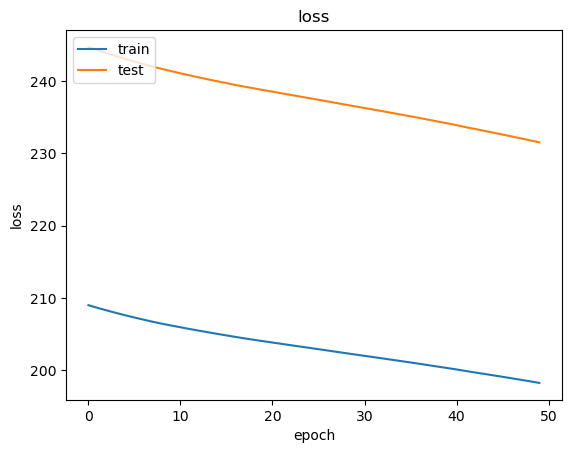

Epoch 1/100
40/40 [==============================] - 1s 8ms/step - loss: 208.2391 - val_loss: 242.5473
Epoch 2/100
40/40 [==============================] - 0s 6ms/step - loss: 206.6216 - val_loss: 241.1589
Epoch 3/100
40/40 [==============================] - 0s 6ms/step - loss: 205.6926 - val_loss: 240.2240
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 205.0414 - val_loss: 239.5121
Epoch 5/100
40/40 [==============================] - 0s 6ms/step - loss: 204.5221 - val_loss: 238.9348
Epoch 6/100
40/40 [==============================] - 0s 6ms/step - loss: 204.0823 - val_loss: 238.4363
Epoch 7/100
40/40 [==============================] - 0s 6ms/step - loss: 203.7018 - val_loss: 238.0090
Epoch 8/100
40/40 [==============================] - 0s 6ms/step - loss: 203.3617 - val_loss: 237.6283
Epoch 9/100
40/40 [==============================] - 0s 6ms/step - loss: 203.0524 - val_loss: 237.2611
Epoch 10/100
40/40 [==============================] - 0s 6ms/step - loss:

Epoch 80/100
40/40 [==============================] - 0s 5ms/step - loss: 185.0246 - val_loss: 214.9066
Epoch 81/100
40/40 [==============================] - 0s 5ms/step - loss: 184.7022 - val_loss: 214.5240
Epoch 82/100
40/40 [==============================] - 0s 5ms/step - loss: 184.3833 - val_loss: 214.1138
Epoch 83/100
40/40 [==============================] - 0s 5ms/step - loss: 184.0573 - val_loss: 213.7054
Epoch 84/100
40/40 [==============================] - 0s 5ms/step - loss: 183.7242 - val_loss: 213.2793
Epoch 85/100
40/40 [==============================] - 0s 5ms/step - loss: 183.3864 - val_loss: 212.8678
Epoch 86/100
40/40 [==============================] - 0s 5ms/step - loss: 183.0508 - val_loss: 212.4538
Epoch 87/100
40/40 [==============================] - 0s 5ms/step - loss: 182.7121 - val_loss: 212.0320
Epoch 88/100
40/40 [==============================] - 0s 5ms/step - loss: 182.3793 - val_loss: 211.6092
Epoch 89/100
40/40 [==============================] - 0s 5ms/ste

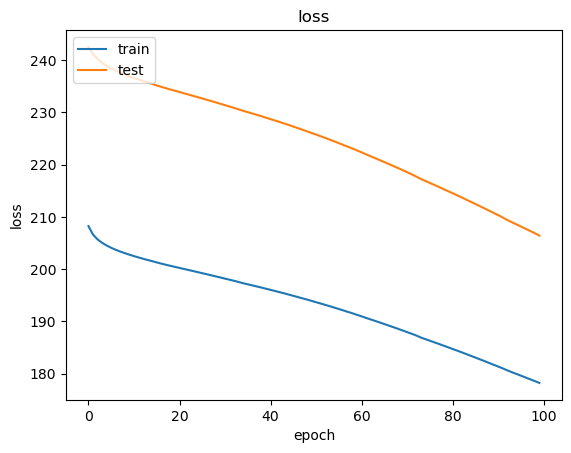

Epoch 1/300
40/40 [==============================] - 1s 8ms/step - loss: 207.9628 - val_loss: 242.0318
Epoch 2/300
40/40 [==============================] - 0s 6ms/step - loss: 206.4799 - val_loss: 240.8173
Epoch 3/300
40/40 [==============================] - 0s 6ms/step - loss: 205.6384 - val_loss: 240.0207
Epoch 4/300
40/40 [==============================] - 0s 6ms/step - loss: 205.0338 - val_loss: 239.4219
Epoch 5/300
40/40 [==============================] - 0s 6ms/step - loss: 204.5513 - val_loss: 238.8991
Epoch 6/300
40/40 [==============================] - 0s 6ms/step - loss: 204.1365 - val_loss: 238.4612
Epoch 7/300
40/40 [==============================] - 0s 6ms/step - loss: 203.7917 - val_loss: 238.0761
Epoch 8/300
40/40 [==============================] - 0s 6ms/step - loss: 203.4788 - val_loss: 237.7318
Epoch 9/300
40/40 [==============================] - 0s 6ms/step - loss: 203.1927 - val_loss: 237.4181
Epoch 10/300
40/40 [==============================] - 0s 6ms/step - loss:

Epoch 80/300
40/40 [==============================] - 0s 6ms/step - loss: 183.5598 - val_loss: 213.1920
Epoch 81/300
40/40 [==============================] - 0s 6ms/step - loss: 183.2189 - val_loss: 212.7451
Epoch 82/300
40/40 [==============================] - 0s 6ms/step - loss: 182.8682 - val_loss: 212.3091
Epoch 83/300
40/40 [==============================] - 0s 6ms/step - loss: 182.5178 - val_loss: 211.8632
Epoch 84/300
40/40 [==============================] - 0s 6ms/step - loss: 182.1618 - val_loss: 211.4255
Epoch 85/300
40/40 [==============================] - 0s 6ms/step - loss: 181.7971 - val_loss: 210.9536
Epoch 86/300
40/40 [==============================] - 0s 6ms/step - loss: 181.4373 - val_loss: 210.4880
Epoch 87/300
40/40 [==============================] - 0s 6ms/step - loss: 181.0642 - val_loss: 210.0334
Epoch 88/300
40/40 [==============================] - 0s 6ms/step - loss: 180.7037 - val_loss: 209.5627
Epoch 89/300
40/40 [==============================] - 0s 6ms/ste

40/40 [==============================] - 0s 5ms/step - loss: 135.2713 - val_loss: 152.8786
Epoch 237/300
40/40 [==============================] - 0s 5ms/step - loss: 135.0774 - val_loss: 152.6385
Epoch 238/300
40/40 [==============================] - 0s 5ms/step - loss: 134.8841 - val_loss: 152.3808
Epoch 239/300
40/40 [==============================] - 0s 5ms/step - loss: 134.6871 - val_loss: 152.1441
Epoch 240/300
40/40 [==============================] - 0s 6ms/step - loss: 134.4969 - val_loss: 151.9097
Epoch 241/300
40/40 [==============================] - 0s 6ms/step - loss: 134.3105 - val_loss: 151.6777
Epoch 242/300
40/40 [==============================] - 0s 6ms/step - loss: 134.1233 - val_loss: 151.4568
Epoch 243/300
40/40 [==============================] - 0s 6ms/step - loss: 133.9403 - val_loss: 151.2224
Epoch 244/300
40/40 [==============================] - 0s 6ms/step - loss: 133.7556 - val_loss: 150.9982
Epoch 245/300
40/40 [==============================] - 0s 6ms/step - 

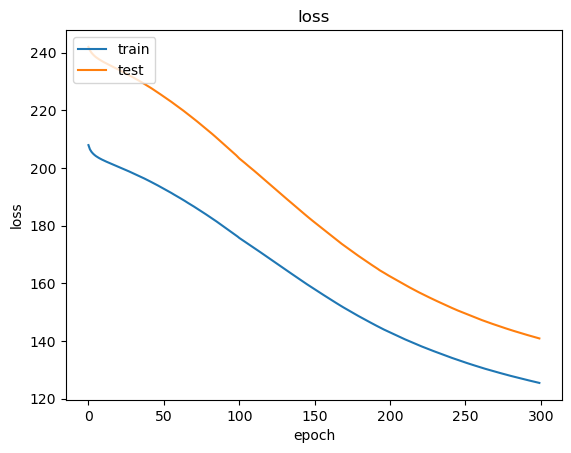

Epoch 1/50
10/10 [==============================] - 1s 24ms/step - loss: 208.8731 - val_loss: 244.3429
Epoch 2/50
10/10 [==============================] - 0s 11ms/step - loss: 208.1432 - val_loss: 243.4741
Epoch 3/50
10/10 [==============================] - 0s 11ms/step - loss: 207.5033 - val_loss: 242.7502
Epoch 4/50
10/10 [==============================] - 0s 11ms/step - loss: 206.9824 - val_loss: 242.1501
Epoch 5/50
10/10 [==============================] - 0s 10ms/step - loss: 206.5341 - val_loss: 241.6642
Epoch 6/50
10/10 [==============================] - 0s 11ms/step - loss: 206.1654 - val_loss: 241.2485
Epoch 7/50
10/10 [==============================] - 0s 11ms/step - loss: 205.8441 - val_loss: 240.8873
Epoch 8/50
10/10 [==============================] - 0s 11ms/step - loss: 205.5748 - val_loss: 240.5537
Epoch 9/50
10/10 [==============================] - 0s 11ms/step - loss: 205.3118 - val_loss: 240.2642
Epoch 10/50
10/10 [==============================] - 0s 11ms/step - loss:

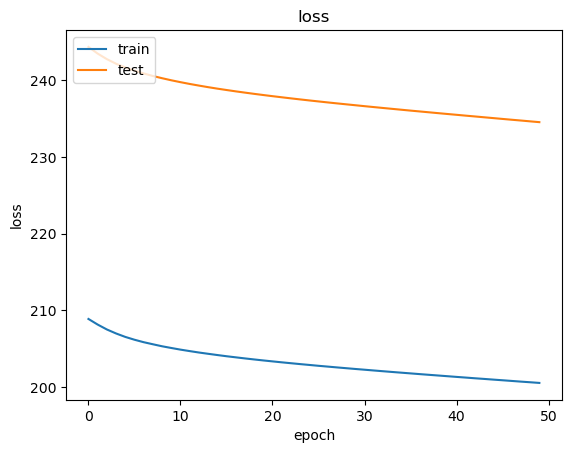

Epoch 1/100
10/10 [==============================] - 1s 27ms/step - loss: 207.6507 - val_loss: 242.7639
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 206.9803 - val_loss: 241.9988
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 206.4120 - val_loss: 241.3548
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 205.9280 - val_loss: 240.8338
Epoch 5/100
10/10 [==============================] - 0s 14ms/step - loss: 205.5297 - val_loss: 240.4082
Epoch 6/100
10/10 [==============================] - 0s 14ms/step - loss: 205.2000 - val_loss: 240.0457
Epoch 7/100
10/10 [==============================] - 0s 14ms/step - loss: 204.9120 - val_loss: 239.7267
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 204.6618 - val_loss: 239.4393
Epoch 9/100
10/10 [==============================] - 0s 14ms/step - loss: 204.4320 - val_loss: 239.1811
Epoch 10/100
10/10 [==============================] - 0s 13ms/st

10/10 [==============================] - 0s 14ms/step - loss: 197.1141 - val_loss: 230.3058
Epoch 80/100
10/10 [==============================] - 0s 13ms/step - loss: 197.0171 - val_loss: 230.1838
Epoch 81/100
10/10 [==============================] - 0s 13ms/step - loss: 196.9222 - val_loss: 230.0573
Epoch 82/100
10/10 [==============================] - 0s 13ms/step - loss: 196.8219 - val_loss: 229.9334
Epoch 83/100
10/10 [==============================] - 0s 12ms/step - loss: 196.7239 - val_loss: 229.8082
Epoch 84/100
10/10 [==============================] - 0s 14ms/step - loss: 196.6255 - val_loss: 229.6821
Epoch 85/100
10/10 [==============================] - 0s 12ms/step - loss: 196.5237 - val_loss: 229.5596
Epoch 86/100
10/10 [==============================] - 0s 13ms/step - loss: 196.4270 - val_loss: 229.4320
Epoch 87/100
10/10 [==============================] - 0s 14ms/step - loss: 196.3235 - val_loss: 229.3088
Epoch 88/100
10/10 [==============================] - 0s 13ms/step -

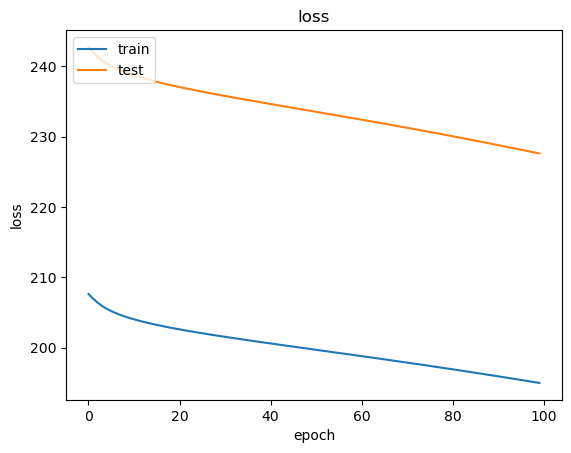

Epoch 1/300
10/10 [==============================] - 1s 26ms/step - loss: 208.3934 - val_loss: 244.1019
Epoch 2/300
10/10 [==============================] - 0s 14ms/step - loss: 207.6551 - val_loss: 243.2309
Epoch 3/300
10/10 [==============================] - 0s 14ms/step - loss: 207.0172 - val_loss: 242.5075
Epoch 4/300
10/10 [==============================] - 0s 13ms/step - loss: 206.5027 - val_loss: 241.9264
Epoch 5/300
10/10 [==============================] - 0s 13ms/step - loss: 206.0687 - val_loss: 241.4555
Epoch 6/300
10/10 [==============================] - 0s 13ms/step - loss: 205.7096 - val_loss: 241.0592
Epoch 7/300
10/10 [==============================] - 0s 12ms/step - loss: 205.4096 - val_loss: 240.7082
Epoch 8/300
10/10 [==============================] - 0s 14ms/step - loss: 205.1414 - val_loss: 240.3985
Epoch 9/300
10/10 [==============================] - 0s 13ms/step - loss: 204.8999 - val_loss: 240.1167
Epoch 10/300
10/10 [==============================] - 0s 13ms/st

10/10 [==============================] - 0s 14ms/step - loss: 197.6017 - val_loss: 231.1078
Epoch 80/300
10/10 [==============================] - 0s 14ms/step - loss: 197.5094 - val_loss: 230.9911
Epoch 81/300
10/10 [==============================] - 0s 13ms/step - loss: 197.4159 - val_loss: 230.8754
Epoch 82/300
10/10 [==============================] - 0s 14ms/step - loss: 197.3241 - val_loss: 230.7572
Epoch 83/300
10/10 [==============================] - 0s 14ms/step - loss: 197.2305 - val_loss: 230.6384
Epoch 84/300
10/10 [==============================] - 0s 13ms/step - loss: 197.1361 - val_loss: 230.5206
Epoch 85/300
10/10 [==============================] - 0s 15ms/step - loss: 197.0418 - val_loss: 230.4017
Epoch 86/300
10/10 [==============================] - 0s 14ms/step - loss: 196.9487 - val_loss: 230.2813
Epoch 87/300
10/10 [==============================] - 0s 14ms/step - loss: 196.8537 - val_loss: 230.1625
Epoch 88/300
10/10 [==============================] - 0s 13ms/step -

10/10 [==============================] - 0s 13ms/step - loss: 180.2619 - val_loss: 209.2161
Epoch 234/300
10/10 [==============================] - 0s 13ms/step - loss: 180.1321 - val_loss: 209.0584
Epoch 235/300
10/10 [==============================] - 0s 13ms/step - loss: 180.0033 - val_loss: 208.9045
Epoch 236/300
10/10 [==============================] - 0s 13ms/step - loss: 179.8802 - val_loss: 208.7452
Epoch 237/300
10/10 [==============================] - 0s 13ms/step - loss: 179.7548 - val_loss: 208.5858
Epoch 238/300
10/10 [==============================] - 0s 13ms/step - loss: 179.6275 - val_loss: 208.4257
Epoch 239/300
10/10 [==============================] - 0s 13ms/step - loss: 179.5027 - val_loss: 208.2646
Epoch 240/300
10/10 [==============================] - 0s 13ms/step - loss: 179.3759 - val_loss: 208.1046
Epoch 241/300
10/10 [==============================] - 0s 13ms/step - loss: 179.2464 - val_loss: 207.9487
Epoch 242/300
10/10 [==============================] - 0s 13

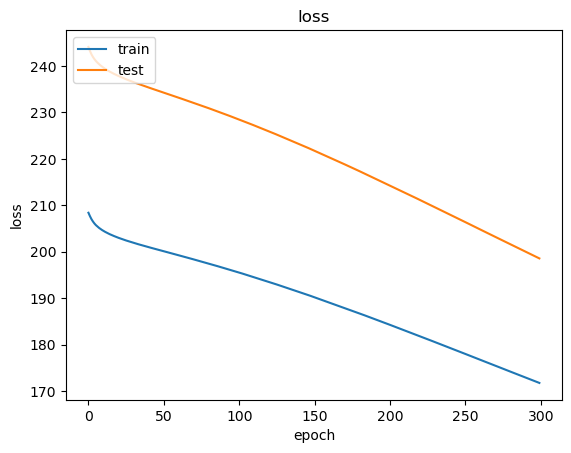

In [98]:
erg=[]
for opt in opti:
    for b in bs:
        for e in epochs:
            autoencoder_small = Autoencoder_small()
            autoencoder_small.compile(optimizer=opt, loss=loss)
            erg.append(train_model(autoencoder_small,X_nomt_train,X_nomt_test,_,opt,e,b))
           

bs=128
epoch=300

Epoch 1/500
20/20 [==============================] - 1s 17ms/step - loss: 202.7043 - val_loss: 231.7837
Epoch 2/500
20/20 [==============================] - 0s 15ms/step - loss: 192.7297 - val_loss: 215.0820
Epoch 3/500
20/20 [==============================] - 0s 6ms/step - loss: 175.4930 - val_loss: 187.7291
Epoch 4/500
20/20 [==============================] - 0s 6ms/step - loss: 153.4939 - val_loss: 161.6965
Epoch 5/500
20/20 [==============================] - 0s 7ms/step - loss: 135.8432 - val_loss: 144.6508
Epoch 6/500
20/20 [==============================] - 0s 7ms/step - loss: 124.9302 - val_loss: 134.8199
Epoch 7/500
20/20 [==============================] - 0s 7ms/step - loss: 118.0650 - val_loss: 128.6154
Epoch 8/500
20/20 [==============================] - 0s 8ms/step - loss: 113.2442 - val_loss: 123.4280
Epoch 9/500
20/20 [==============================] - 0s 7ms/step - loss: 108.9230 - val_loss: 118.7613
Epoch 10/500
20/20 [==============================] - 0s 7ms/step - los

Epoch 161/500
20/20 [==============================] - 0s 8ms/step - loss: 34.9571 - val_loss: 43.0454
Epoch 162/500
20/20 [==============================] - 0s 8ms/step - loss: 34.8778 - val_loss: 43.0022
Epoch 163/500
20/20 [==============================] - 0s 8ms/step - loss: 34.8090 - val_loss: 42.9300
Epoch 164/500
20/20 [==============================] - 0s 8ms/step - loss: 34.7555 - val_loss: 42.8707
Epoch 165/500
20/20 [==============================] - 0s 8ms/step - loss: 34.6724 - val_loss: 42.7390
Epoch 166/500
20/20 [==============================] - 0s 7ms/step - loss: 34.6110 - val_loss: 42.6936
Epoch 167/500
20/20 [==============================] - 0s 7ms/step - loss: 34.5544 - val_loss: 42.6075
Epoch 168/500
20/20 [==============================] - 0s 8ms/step - loss: 34.4781 - val_loss: 42.5509
Epoch 169/500
20/20 [==============================] - 0s 8ms/step - loss: 34.4112 - val_loss: 42.5008
Epoch 170/500
20/20 [==============================] - 0s 7ms/step - loss

20/20 [==============================] - 0s 7ms/step - loss: 29.5846 - val_loss: 37.5247
Epoch 320/500
20/20 [==============================] - 0s 8ms/step - loss: 29.5765 - val_loss: 37.5581
Epoch 321/500
20/20 [==============================] - 0s 8ms/step - loss: 29.5643 - val_loss: 37.5354
Epoch 322/500
20/20 [==============================] - 0s 8ms/step - loss: 29.5454 - val_loss: 37.5425
Epoch 323/500
20/20 [==============================] - 0s 7ms/step - loss: 29.5348 - val_loss: 37.5133
Epoch 324/500
20/20 [==============================] - 0s 8ms/step - loss: 29.5308 - val_loss: 37.5370
Epoch 325/500
20/20 [==============================] - 0s 8ms/step - loss: 29.5130 - val_loss: 37.4903
Epoch 326/500
20/20 [==============================] - 0s 8ms/step - loss: 29.4998 - val_loss: 37.4633
Epoch 327/500
20/20 [==============================] - 0s 8ms/step - loss: 29.4897 - val_loss: 37.4535
Epoch 328/500
20/20 [==============================] - 0s 8ms/step - loss: 29.4752 - va

20/20 [==============================] - 0s 8ms/step - loss: 28.5210 - val_loss: 36.6995
Epoch 478/500
20/20 [==============================] - 0s 8ms/step - loss: 28.5161 - val_loss: 36.6919
Epoch 479/500
20/20 [==============================] - 0s 8ms/step - loss: 28.5070 - val_loss: 36.6765
Epoch 480/500
20/20 [==============================] - 0s 7ms/step - loss: 28.5018 - val_loss: 36.6772
Epoch 481/500
20/20 [==============================] - 0s 7ms/step - loss: 28.5063 - val_loss: 36.6672
Epoch 482/500
20/20 [==============================] - 0s 8ms/step - loss: 28.5045 - val_loss: 36.6505
Epoch 483/500
20/20 [==============================] - 0s 8ms/step - loss: 28.4876 - val_loss: 36.6655
Epoch 484/500
20/20 [==============================] - 0s 8ms/step - loss: 28.4973 - val_loss: 36.6757
Epoch 485/500
20/20 [==============================] - 0s 7ms/step - loss: 28.4911 - val_loss: 36.6617
Epoch 486/500
20/20 [==============================] - 0s 8ms/step - loss: 28.4797 - va

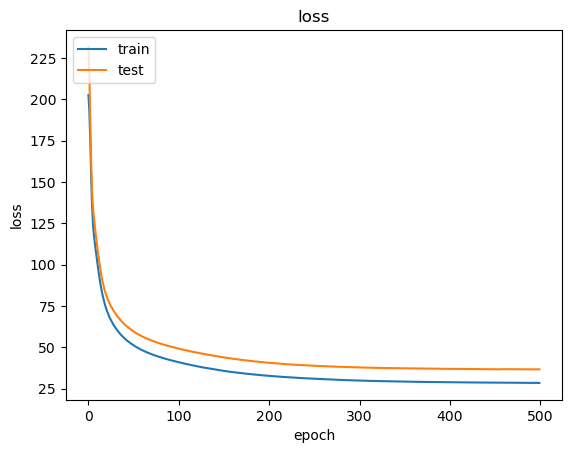

Epoch 1/500
20/20 [==============================] - 1s 14ms/step - loss: 179.9952 - val_loss: 153.0489
Epoch 2/500
20/20 [==============================] - 0s 8ms/step - loss: 121.2057 - val_loss: 117.0796
Epoch 3/500
20/20 [==============================] - 0s 8ms/step - loss: 100.0374 - val_loss: 101.0047
Epoch 4/500
20/20 [==============================] - 0s 8ms/step - loss: 87.9062 - val_loss: 90.4353
Epoch 5/500
20/20 [==============================] - 0s 9ms/step - loss: 79.4460 - val_loss: 83.1488
Epoch 6/500
20/20 [==============================] - 0s 8ms/step - loss: 73.2561 - val_loss: 77.6015
Epoch 7/500
20/20 [==============================] - 0s 8ms/step - loss: 68.8900 - val_loss: 73.5161
Epoch 8/500
20/20 [==============================] - 0s 8ms/step - loss: 65.4557 - val_loss: 70.4619
Epoch 9/500
20/20 [==============================] - 0s 8ms/step - loss: 63.0767 - val_loss: 68.2877
Epoch 10/500
20/20 [==============================] - 0s 8ms/step - loss: 60.8170 - 

Epoch 161/500
20/20 [==============================] - 0s 9ms/step - loss: 32.5002 - val_loss: 38.5374
Epoch 162/500
20/20 [==============================] - 0s 9ms/step - loss: 32.4604 - val_loss: 38.4890
Epoch 163/500
20/20 [==============================] - 0s 8ms/step - loss: 32.4605 - val_loss: 38.4520
Epoch 164/500
20/20 [==============================] - 0s 8ms/step - loss: 32.3924 - val_loss: 38.3758
Epoch 165/500
20/20 [==============================] - 0s 9ms/step - loss: 32.3771 - val_loss: 38.4155
Epoch 166/500
20/20 [==============================] - 0s 8ms/step - loss: 32.3472 - val_loss: 38.3739
Epoch 167/500
20/20 [==============================] - 0s 8ms/step - loss: 32.2614 - val_loss: 38.3193
Epoch 168/500
20/20 [==============================] - 0s 8ms/step - loss: 32.2581 - val_loss: 38.2294
Epoch 169/500
20/20 [==============================] - 0s 8ms/step - loss: 32.2416 - val_loss: 38.2317
Epoch 170/500
20/20 [==============================] - 0s 9ms/step - loss

20/20 [==============================] - 0s 8ms/step - loss: 29.9929 - val_loss: 35.6701
Epoch 320/500
20/20 [==============================] - 0s 8ms/step - loss: 30.0278 - val_loss: 35.6604
Epoch 321/500
20/20 [==============================] - 0s 8ms/step - loss: 30.0378 - val_loss: 35.6477
Epoch 322/500
20/20 [==============================] - 0s 8ms/step - loss: 30.0385 - val_loss: 35.6185
Epoch 323/500
20/20 [==============================] - 0s 8ms/step - loss: 30.0087 - val_loss: 35.6032
Epoch 324/500
20/20 [==============================] - 0s 8ms/step - loss: 29.9755 - val_loss: 35.6110
Epoch 325/500
20/20 [==============================] - 0s 8ms/step - loss: 29.9525 - val_loss: 35.6026
Epoch 326/500
20/20 [==============================] - 0s 8ms/step - loss: 30.0140 - val_loss: 35.6074
Epoch 327/500
20/20 [==============================] - 0s 8ms/step - loss: 30.0090 - val_loss: 35.5854
Epoch 328/500
20/20 [==============================] - 0s 9ms/step - loss: 29.9916 - va

20/20 [==============================] - 0s 9ms/step - loss: 29.3838 - val_loss: 34.7842
Epoch 478/500
20/20 [==============================] - 0s 8ms/step - loss: 29.4288 - val_loss: 34.8247
Epoch 479/500
20/20 [==============================] - 0s 8ms/step - loss: 29.3544 - val_loss: 34.7787
Epoch 480/500
20/20 [==============================] - 0s 9ms/step - loss: 29.3628 - val_loss: 34.7566
Epoch 481/500
20/20 [==============================] - 0s 9ms/step - loss: 29.3587 - val_loss: 34.7880
Epoch 482/500
20/20 [==============================] - 0s 8ms/step - loss: 29.3776 - val_loss: 34.8150
Epoch 483/500
20/20 [==============================] - 0s 9ms/step - loss: 29.3503 - val_loss: 34.7581
Epoch 484/500
20/20 [==============================] - 0s 9ms/step - loss: 29.4042 - val_loss: 34.7638
Epoch 485/500
20/20 [==============================] - 0s 9ms/step - loss: 29.4090 - val_loss: 34.8027
Epoch 486/500
20/20 [==============================] - 0s 8ms/step - loss: 29.3926 - va

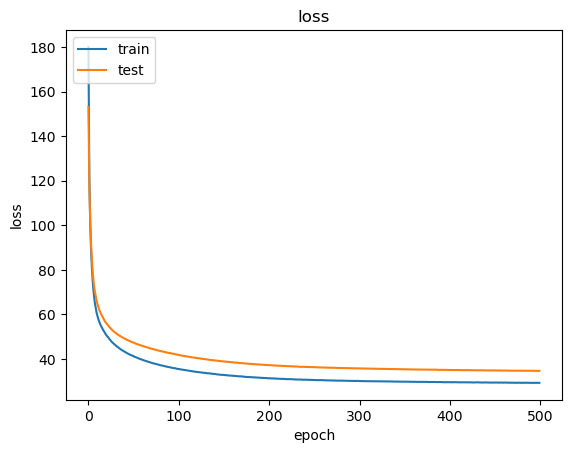

Epoch 1/500
20/20 [==============================] - 1s 14ms/step - loss: 208.2876 - val_loss: 242.4594
Epoch 2/500
20/20 [==============================] - 0s 9ms/step - loss: 206.4723 - val_loss: 240.6164
Epoch 3/500
20/20 [==============================] - 0s 10ms/step - loss: 205.1451 - val_loss: 239.2442
Epoch 4/500
20/20 [==============================] - 0s 9ms/step - loss: 204.0869 - val_loss: 238.1498
Epoch 5/500
20/20 [==============================] - 0s 8ms/step - loss: 203.2078 - val_loss: 237.1433
Epoch 6/500
20/20 [==============================] - 0s 8ms/step - loss: 202.3683 - val_loss: 236.2086
Epoch 7/500
20/20 [==============================] - 0s 8ms/step - loss: 201.5501 - val_loss: 235.2357
Epoch 8/500
20/20 [==============================] - 0s 9ms/step - loss: 200.7024 - val_loss: 234.1539
Epoch 9/500
20/20 [==============================] - 0s 8ms/step - loss: 199.7856 - val_loss: 232.9150
Epoch 10/500
20/20 [==============================] - 0s 8ms/step - los

Epoch 80/500
20/20 [==============================] - 0s 8ms/step - loss: 108.4286 - val_loss: 121.4917
Epoch 81/500
20/20 [==============================] - 0s 8ms/step - loss: 108.0464 - val_loss: 121.0693
Epoch 82/500
20/20 [==============================] - 0s 8ms/step - loss: 107.6533 - val_loss: 120.6545
Epoch 83/500
20/20 [==============================] - 0s 9ms/step - loss: 107.2709 - val_loss: 120.2374
Epoch 84/500
20/20 [==============================] - 0s 8ms/step - loss: 106.8856 - val_loss: 119.8468
Epoch 85/500
20/20 [==============================] - 0s 9ms/step - loss: 106.5032 - val_loss: 119.4256
Epoch 86/500
20/20 [==============================] - 0s 8ms/step - loss: 106.1209 - val_loss: 119.0047
Epoch 87/500
20/20 [==============================] - 0s 8ms/step - loss: 105.7439 - val_loss: 118.6152
Epoch 88/500
20/20 [==============================] - 0s 8ms/step - loss: 105.3691 - val_loss: 118.1934
Epoch 89/500
20/20 [==============================] - 0s 8ms/ste

Epoch 159/500
20/20 [==============================] - 0s 8ms/step - loss: 83.9860 - val_loss: 94.8838
Epoch 160/500
20/20 [==============================] - 0s 8ms/step - loss: 83.7586 - val_loss: 94.6411
Epoch 161/500
20/20 [==============================] - 0s 8ms/step - loss: 83.5389 - val_loss: 94.4017
Epoch 162/500
20/20 [==============================] - 0s 8ms/step - loss: 83.3123 - val_loss: 94.1481
Epoch 163/500
20/20 [==============================] - 0s 8ms/step - loss: 83.0944 - val_loss: 93.9175
Epoch 164/500
20/20 [==============================] - 0s 8ms/step - loss: 82.8728 - val_loss: 93.6812
Epoch 165/500
20/20 [==============================] - 0s 8ms/step - loss: 82.6657 - val_loss: 93.4360
Epoch 166/500
20/20 [==============================] - 0s 8ms/step - loss: 82.4462 - val_loss: 93.2089
Epoch 167/500
20/20 [==============================] - 0s 9ms/step - loss: 82.2288 - val_loss: 92.9538
Epoch 168/500
20/20 [==============================] - 0s 8ms/step - loss

20/20 [==============================] - 0s 9ms/step - loss: 61.7850 - val_loss: 71.6800
Epoch 318/500
20/20 [==============================] - 0s 8ms/step - loss: 61.6926 - val_loss: 71.5995
Epoch 319/500
20/20 [==============================] - 0s 8ms/step - loss: 61.6164 - val_loss: 71.5146
Epoch 320/500
20/20 [==============================] - 0s 8ms/step - loss: 61.5331 - val_loss: 71.4266
Epoch 321/500
20/20 [==============================] - 0s 8ms/step - loss: 61.4525 - val_loss: 71.3467
Epoch 322/500
20/20 [==============================] - 0s 8ms/step - loss: 61.3760 - val_loss: 71.2761
Epoch 323/500
20/20 [==============================] - 0s 8ms/step - loss: 61.2944 - val_loss: 71.1821
Epoch 324/500
20/20 [==============================] - 0s 8ms/step - loss: 61.2075 - val_loss: 71.1010
Epoch 325/500
20/20 [==============================] - 0s 8ms/step - loss: 61.1295 - val_loss: 71.0183
Epoch 326/500
20/20 [==============================] - 0s 9ms/step - loss: 61.0495 - va

20/20 [==============================] - 0s 9ms/step - loss: 52.8752 - val_loss: 62.2329
Epoch 476/500
20/20 [==============================] - 0s 8ms/step - loss: 52.8379 - val_loss: 62.1895
Epoch 477/500
20/20 [==============================] - 0s 9ms/step - loss: 52.7917 - val_loss: 62.1527
Epoch 478/500
20/20 [==============================] - 0s 8ms/step - loss: 52.7480 - val_loss: 62.1046
Epoch 479/500
20/20 [==============================] - 0s 8ms/step - loss: 52.7099 - val_loss: 62.0723
Epoch 480/500
20/20 [==============================] - 0s 8ms/step - loss: 52.6677 - val_loss: 62.0245
Epoch 481/500
20/20 [==============================] - 0s 9ms/step - loss: 52.6271 - val_loss: 61.9704
Epoch 482/500
20/20 [==============================] - 0s 8ms/step - loss: 52.5852 - val_loss: 61.9382
Epoch 483/500
20/20 [==============================] - 0s 8ms/step - loss: 52.5504 - val_loss: 61.8935
Epoch 484/500
20/20 [==============================] - 0s 8ms/step - loss: 52.5091 - va

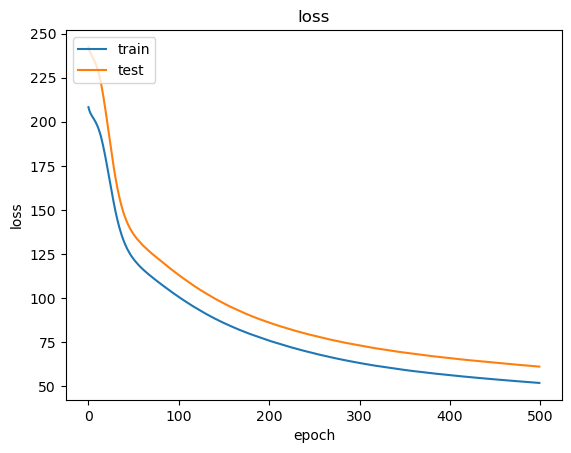

Epoch 1/500
20/20 [==============================] - 1s 43ms/step - loss: 207.2484 - val_loss: 236.3858
Epoch 2/500
20/20 [==============================] - 0s 10ms/step - loss: 202.3918 - val_loss: 232.0822
Epoch 3/500
20/20 [==============================] - 0s 10ms/step - loss: 198.5291 - val_loss: 226.8065
Epoch 4/500
20/20 [==============================] - 0s 8ms/step - loss: 193.7495 - val_loss: 220.3483
Epoch 5/500
20/20 [==============================] - 0s 9ms/step - loss: 188.1668 - val_loss: 212.4207
Epoch 6/500
20/20 [==============================] - 0s 9ms/step - loss: 181.4914 - val_loss: 203.9980
Epoch 7/500
20/20 [==============================] - 0s 9ms/step - loss: 174.6640 - val_loss: 195.5138
Epoch 8/500
20/20 [==============================] - 0s 9ms/step - loss: 167.8353 - val_loss: 187.2821
Epoch 9/500
20/20 [==============================] - 0s 9ms/step - loss: 161.3834 - val_loss: 179.4601
Epoch 10/500
20/20 [==============================] - 0s 9ms/step - lo

20/20 [==============================] - 0s 8ms/step - loss: 91.2892 - val_loss: 100.0823
Epoch 81/500
20/20 [==============================] - 0s 9ms/step - loss: 91.0071 - val_loss: 99.7328
Epoch 82/500
20/20 [==============================] - 0s 9ms/step - loss: 90.6884 - val_loss: 99.4233
Epoch 83/500
20/20 [==============================] - 0s 9ms/step - loss: 90.3873 - val_loss: 99.1112
Epoch 84/500
20/20 [==============================] - 0s 9ms/step - loss: 90.0877 - val_loss: 98.7968
Epoch 85/500
20/20 [==============================] - 0s 9ms/step - loss: 89.9004 - val_loss: 98.4911
Epoch 86/500
20/20 [==============================] - 0s 8ms/step - loss: 89.5808 - val_loss: 98.1883
Epoch 87/500
20/20 [==============================] - 0s 9ms/step - loss: 89.3315 - val_loss: 97.8871
Epoch 88/500
20/20 [==============================] - 0s 9ms/step - loss: 89.0784 - val_loss: 97.5785
Epoch 89/500
20/20 [==============================] - 0s 9ms/step - loss: 88.7617 - val_loss: 

Epoch 160/500
20/20 [==============================] - 0s 8ms/step - loss: 74.8823 - val_loss: 82.4802
Epoch 161/500
20/20 [==============================] - 0s 8ms/step - loss: 74.7505 - val_loss: 82.3184
Epoch 162/500
20/20 [==============================] - 0s 9ms/step - loss: 74.5993 - val_loss: 82.1563
Epoch 163/500
20/20 [==============================] - 0s 9ms/step - loss: 74.4549 - val_loss: 82.0104
Epoch 164/500
20/20 [==============================] - 0s 9ms/step - loss: 74.2631 - val_loss: 81.8409
Epoch 165/500
20/20 [==============================] - 0s 9ms/step - loss: 74.1512 - val_loss: 81.6931
Epoch 166/500
20/20 [==============================] - 0s 8ms/step - loss: 74.0258 - val_loss: 81.5383
Epoch 167/500
20/20 [==============================] - 0s 9ms/step - loss: 73.8218 - val_loss: 81.3856
Epoch 168/500
20/20 [==============================] - 0s 9ms/step - loss: 73.7186 - val_loss: 81.2253
Epoch 169/500
20/20 [==============================] - 0s 9ms/step - loss

20/20 [==============================] - 0s 7ms/step - loss: 59.0755 - val_loss: 66.2584
Epoch 319/500
20/20 [==============================] - 0s 7ms/step - loss: 58.9891 - val_loss: 66.1941
Epoch 320/500
20/20 [==============================] - 0s 7ms/step - loss: 58.9845 - val_loss: 66.1342
Epoch 321/500
20/20 [==============================] - 0s 7ms/step - loss: 58.9038 - val_loss: 66.0692
Epoch 322/500
20/20 [==============================] - 0s 8ms/step - loss: 58.7878 - val_loss: 66.0023
Epoch 323/500
20/20 [==============================] - 0s 8ms/step - loss: 58.8011 - val_loss: 65.9477
Epoch 324/500
20/20 [==============================] - 0s 7ms/step - loss: 58.6978 - val_loss: 65.8770
Epoch 325/500
20/20 [==============================] - 0s 7ms/step - loss: 58.5925 - val_loss: 65.8155
Epoch 326/500
20/20 [==============================] - 0s 8ms/step - loss: 58.5852 - val_loss: 65.7596
Epoch 327/500
20/20 [==============================] - 0s 8ms/step - loss: 58.5080 - va

20/20 [==============================] - 0s 8ms/step - loss: 51.5537 - val_loss: 58.6852
Epoch 477/500
20/20 [==============================] - 0s 9ms/step - loss: 51.5682 - val_loss: 58.6395
Epoch 478/500
20/20 [==============================] - 0s 9ms/step - loss: 51.5006 - val_loss: 58.6104
Epoch 479/500
20/20 [==============================] - 0s 9ms/step - loss: 51.4830 - val_loss: 58.5643
Epoch 480/500
20/20 [==============================] - 0s 8ms/step - loss: 51.4619 - val_loss: 58.5233
Epoch 481/500
20/20 [==============================] - 0s 9ms/step - loss: 51.3445 - val_loss: 58.4879
Epoch 482/500
20/20 [==============================] - 0s 8ms/step - loss: 51.3923 - val_loss: 58.4706
Epoch 483/500
20/20 [==============================] - 0s 8ms/step - loss: 51.3466 - val_loss: 58.4319
Epoch 484/500
20/20 [==============================] - 0s 9ms/step - loss: 51.3402 - val_loss: 58.3839
Epoch 485/500
20/20 [==============================] - 0s 8ms/step - loss: 51.2675 - va

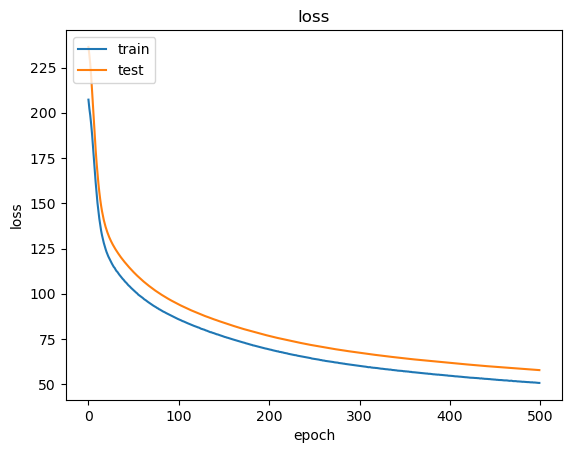

In [136]:
lr_erg=[]
lr_erg_d=[]
for opt in opti:
            autoencoder_small = Autoencoder_small()
            autoencoder_small.compile(optimizer=opt, loss=loss)
            lr_erg.append(train_model(autoencoder_small,X_nomt_train,X_nomt_test,_,opt,500,256))
            autoencoder_small_dropout = Autoencoder_small_dropout()
            autoencoder_small_dropout.compile(optimizer=opt, loss=loss)
            lr_erg_d.append(train_model(autoencoder_small_dropout,X_nomt_train,X_nomt_test,_,opt,500,256))

In [48]:
autoencoder_small.fit(X_nomt_train, X_nomt_train,
                epochs=800,
                batch_size=512,
                shuffle=True,
                validation_data=(X_nomt_test, X_nomt_test))


Epoch 1/800
10/10 [==============================] - 1s 25ms/step - loss: 46.8414 - val_loss: 54.5529
Epoch 2/800
10/10 [==============================] - 0s 12ms/step - loss: 46.5103 - val_loss: 54.4606
Epoch 3/800
10/10 [==============================] - 0s 13ms/step - loss: 46.2737 - val_loss: 54.1798
Epoch 4/800
10/10 [==============================] - 0s 12ms/step - loss: 46.0481 - val_loss: 54.0345
Epoch 5/800
10/10 [==============================] - 0s 11ms/step - loss: 45.8944 - val_loss: 53.9146
Epoch 6/800
10/10 [==============================] - 0s 12ms/step - loss: 45.7159 - val_loss: 53.6830
Epoch 7/800
10/10 [==============================] - 0s 12ms/step - loss: 45.5650 - val_loss: 53.4849
Epoch 8/800
10/10 [==============================] - 0s 11ms/step - loss: 45.4048 - val_loss: 53.3528
Epoch 9/800
10/10 [==============================] - 0s 11ms/step - loss: 45.2260 - val_loss: 53.1800
Epoch 10/800
10/10 [==============================] - 0s 11ms/step - loss: 45.0730

10/10 [==============================] - 0s 14ms/step - loss: 33.2215 - val_loss: 41.0626
Epoch 160/800
10/10 [==============================] - 0s 14ms/step - loss: 33.2023 - val_loss: 41.0439
Epoch 161/800
10/10 [==============================] - 0s 14ms/step - loss: 33.1532 - val_loss: 41.0029
Epoch 162/800
10/10 [==============================] - 0s 14ms/step - loss: 33.1258 - val_loss: 40.9671
Epoch 163/800
10/10 [==============================] - 0s 14ms/step - loss: 33.0882 - val_loss: 40.9186
Epoch 164/800
10/10 [==============================] - 0s 14ms/step - loss: 33.0541 - val_loss: 40.8779
Epoch 165/800
10/10 [==============================] - 0s 13ms/step - loss: 33.0102 - val_loss: 40.8565
Epoch 166/800
10/10 [==============================] - 0s 13ms/step - loss: 32.9789 - val_loss: 40.8166
Epoch 167/800
10/10 [==============================] - 0s 13ms/step - loss: 32.9426 - val_loss: 40.7557
Epoch 168/800
10/10 [==============================] - 0s 13ms/step - loss: 32

Epoch 238/800
10/10 [==============================] - 0s 14ms/step - loss: 31.0621 - val_loss: 38.6092
Epoch 239/800
10/10 [==============================] - 0s 14ms/step - loss: 31.0375 - val_loss: 38.6119
Epoch 240/800
10/10 [==============================] - 0s 14ms/step - loss: 31.0207 - val_loss: 38.5682
Epoch 241/800
10/10 [==============================] - 0s 14ms/step - loss: 30.9951 - val_loss: 38.5440
Epoch 242/800
10/10 [==============================] - 0s 14ms/step - loss: 30.9810 - val_loss: 38.5261
Epoch 243/800
10/10 [==============================] - 0s 14ms/step - loss: 30.9598 - val_loss: 38.5075
Epoch 244/800
10/10 [==============================] - 0s 14ms/step - loss: 30.9456 - val_loss: 38.5080
Epoch 245/800
10/10 [==============================] - 0s 14ms/step - loss: 30.9177 - val_loss: 38.4598
Epoch 246/800
10/10 [==============================] - 0s 14ms/step - loss: 30.9039 - val_loss: 38.4346
Epoch 247/800
10/10 [==============================] - 0s 14ms/s

Epoch 317/800
10/10 [==============================] - 0s 13ms/step - loss: 29.8539 - val_loss: 37.2043
Epoch 318/800
10/10 [==============================] - 0s 13ms/step - loss: 29.8413 - val_loss: 37.2316
Epoch 319/800
10/10 [==============================] - 0s 13ms/step - loss: 29.8382 - val_loss: 37.1892
Epoch 320/800
10/10 [==============================] - 0s 14ms/step - loss: 29.8274 - val_loss: 37.1931
Epoch 321/800
10/10 [==============================] - 0s 14ms/step - loss: 29.8133 - val_loss: 37.1882
Epoch 322/800
10/10 [==============================] - 0s 14ms/step - loss: 29.8035 - val_loss: 37.1414
Epoch 323/800
10/10 [==============================] - 0s 14ms/step - loss: 29.7992 - val_loss: 37.1614
Epoch 324/800
10/10 [==============================] - 0s 14ms/step - loss: 29.7854 - val_loss: 37.1644
Epoch 325/800
10/10 [==============================] - 0s 15ms/step - loss: 29.7727 - val_loss: 37.1191
Epoch 326/800
10/10 [==============================] - 0s 15ms/s

Epoch 396/800
10/10 [==============================] - 0s 14ms/step - loss: 29.1913 - val_loss: 36.4450
Epoch 397/800
10/10 [==============================] - 0s 14ms/step - loss: 29.1859 - val_loss: 36.4193
Epoch 398/800
10/10 [==============================] - 0s 14ms/step - loss: 29.1790 - val_loss: 36.4433
Epoch 399/800
10/10 [==============================] - 0s 14ms/step - loss: 29.1745 - val_loss: 36.4051
Epoch 400/800
10/10 [==============================] - 0s 14ms/step - loss: 29.1749 - val_loss: 36.4290
Epoch 401/800
10/10 [==============================] - 0s 13ms/step - loss: 29.1612 - val_loss: 36.4088
Epoch 402/800
10/10 [==============================] - 0s 14ms/step - loss: 29.1540 - val_loss: 36.3830
Epoch 403/800
10/10 [==============================] - 0s 14ms/step - loss: 29.1472 - val_loss: 36.4085
Epoch 404/800
10/10 [==============================] - 0s 14ms/step - loss: 29.1413 - val_loss: 36.3935
Epoch 405/800
10/10 [==============================] - 0s 13ms/s

Epoch 475/800
10/10 [==============================] - 0s 14ms/step - loss: 28.8082 - val_loss: 36.0225
Epoch 476/800
10/10 [==============================] - 0s 13ms/step - loss: 28.8082 - val_loss: 36.0110
Epoch 477/800
10/10 [==============================] - 0s 13ms/step - loss: 28.7984 - val_loss: 36.0265
Epoch 478/800
10/10 [==============================] - 0s 13ms/step - loss: 28.7952 - val_loss: 36.0185
Epoch 479/800
10/10 [==============================] - 0s 14ms/step - loss: 28.7950 - val_loss: 36.0028
Epoch 480/800
10/10 [==============================] - 0s 14ms/step - loss: 28.8008 - val_loss: 36.0177
Epoch 481/800
10/10 [==============================] - 0s 14ms/step - loss: 28.7910 - val_loss: 36.0039
Epoch 482/800
10/10 [==============================] - 0s 14ms/step - loss: 28.7889 - val_loss: 35.9966
Epoch 483/800
10/10 [==============================] - 0s 14ms/step - loss: 28.7820 - val_loss: 36.0016
Epoch 484/800
10/10 [==============================] - 0s 14ms/s

Epoch 554/800
10/10 [==============================] - 0s 14ms/step - loss: 28.5741 - val_loss: 35.8529
Epoch 555/800
10/10 [==============================] - 0s 14ms/step - loss: 28.5681 - val_loss: 35.8241
Epoch 556/800
10/10 [==============================] - 0s 14ms/step - loss: 28.5634 - val_loss: 35.8435
Epoch 557/800
10/10 [==============================] - 0s 13ms/step - loss: 28.5632 - val_loss: 35.8455
Epoch 558/800
10/10 [==============================] - 0s 14ms/step - loss: 28.5651 - val_loss: 35.8272
Epoch 559/800
10/10 [==============================] - 0s 13ms/step - loss: 28.5564 - val_loss: 35.8345
Epoch 560/800
10/10 [==============================] - 0s 14ms/step - loss: 28.5551 - val_loss: 35.8379
Epoch 561/800
10/10 [==============================] - 0s 13ms/step - loss: 28.5527 - val_loss: 35.8332
Epoch 562/800
10/10 [==============================] - 0s 13ms/step - loss: 28.5506 - val_loss: 35.8357
Epoch 563/800
10/10 [==============================] - 0s 13ms/s

Epoch 633/800
10/10 [==============================] - 0s 13ms/step - loss: 28.4004 - val_loss: 35.7552
Epoch 634/800
10/10 [==============================] - 0s 14ms/step - loss: 28.3958 - val_loss: 35.7800
Epoch 635/800
10/10 [==============================] - 0s 13ms/step - loss: 28.3990 - val_loss: 35.7691
Epoch 636/800
10/10 [==============================] - 0s 13ms/step - loss: 28.3979 - val_loss: 35.7559
Epoch 637/800
10/10 [==============================] - 0s 13ms/step - loss: 28.3918 - val_loss: 35.7819
Epoch 638/800
10/10 [==============================] - 0s 13ms/step - loss: 28.3889 - val_loss: 35.7601
Epoch 639/800
10/10 [==============================] - 0s 14ms/step - loss: 28.3921 - val_loss: 35.7710
Epoch 640/800
10/10 [==============================] - 0s 13ms/step - loss: 28.3898 - val_loss: 35.7711
Epoch 641/800
10/10 [==============================] - 0s 14ms/step - loss: 28.3813 - val_loss: 35.7650
Epoch 642/800
10/10 [==============================] - 0s 14ms/s

Epoch 712/800
10/10 [==============================] - 0s 13ms/step - loss: 28.2614 - val_loss: 35.7607
Epoch 713/800
10/10 [==============================] - 0s 13ms/step - loss: 28.2664 - val_loss: 35.7677
Epoch 714/800
10/10 [==============================] - 0s 13ms/step - loss: 28.2611 - val_loss: 35.7441
Epoch 715/800
10/10 [==============================] - 0s 12ms/step - loss: 28.2634 - val_loss: 35.7697
Epoch 716/800
10/10 [==============================] - 0s 13ms/step - loss: 28.2572 - val_loss: 35.7595
Epoch 717/800
10/10 [==============================] - 0s 13ms/step - loss: 28.2586 - val_loss: 35.7600
Epoch 718/800
10/10 [==============================] - 0s 13ms/step - loss: 28.2572 - val_loss: 35.7411
Epoch 719/800
10/10 [==============================] - 0s 14ms/step - loss: 28.2518 - val_loss: 35.7521
Epoch 720/800
10/10 [==============================] - 0s 13ms/step - loss: 28.2540 - val_loss: 35.7699
Epoch 721/800
10/10 [==============================] - 0s 13ms/s

Epoch 791/800
10/10 [==============================] - 0s 14ms/step - loss: 28.1620 - val_loss: 35.7838
Epoch 792/800
10/10 [==============================] - 0s 14ms/step - loss: 28.1574 - val_loss: 35.7759
Epoch 793/800
10/10 [==============================] - 0s 13ms/step - loss: 28.1583 - val_loss: 35.7662
Epoch 794/800
10/10 [==============================] - 0s 13ms/step - loss: 28.1584 - val_loss: 35.7921
Epoch 795/800
10/10 [==============================] - 0s 12ms/step - loss: 28.1559 - val_loss: 35.7811
Epoch 796/800
10/10 [==============================] - 0s 13ms/step - loss: 28.1590 - val_loss: 35.7705
Epoch 797/800
10/10 [==============================] - 0s 14ms/step - loss: 28.1596 - val_loss: 35.7910
Epoch 798/800
10/10 [==============================] - 0s 13ms/step - loss: 28.1554 - val_loss: 35.7629
Epoch 799/800
10/10 [==============================] - 0s 12ms/step - loss: 28.1524 - val_loss: 35.7669
Epoch 800/800
10/10 [==============================] - 0s 12ms/s

plotting

without Dropout

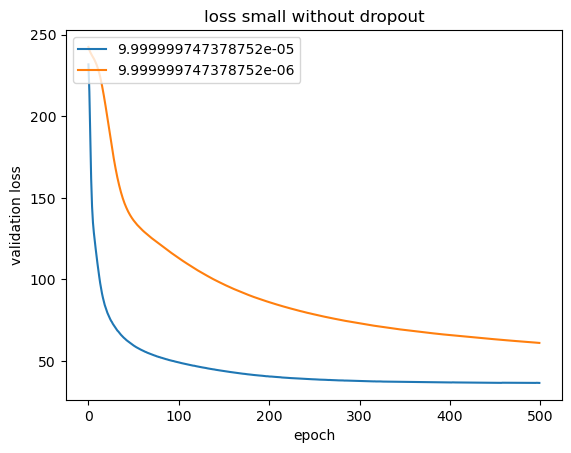

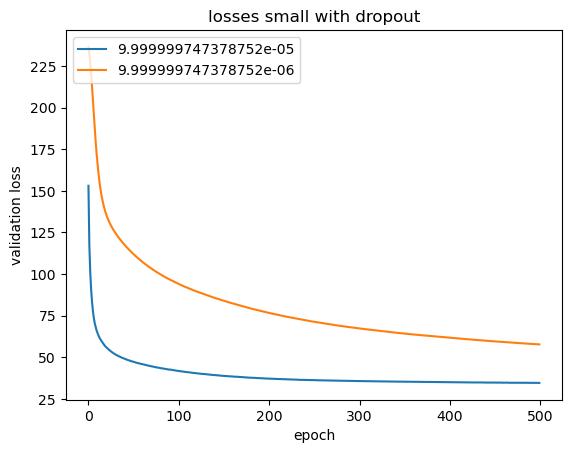

In [138]:
for i in lr_erg:
    plt.plot(i[1],label=f"{i[2]}")
    plt.title('loss small without dropout')
    plt.ylabel('validation loss')
    plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()
for i in lr_erg_d:
    plt.plot(i[1],label=f"{i[2]}")
    plt.title('losses small with dropout')
    plt.ylabel('validation loss')
    plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

### medium

In [151]:
autoencoder_medium.fit(X_nomt_train, X_nomt_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(X_nomt_test, X_nomt_test))

Epoch 1/200
40/40 [==============================] - 1s 11ms/step - loss: 31.4907 - val_loss: 36.2818
Epoch 2/200
40/40 [==============================] - 0s 10ms/step - loss: 31.6527 - val_loss: 36.0614
Epoch 3/200
40/40 [==============================] - 0s 9ms/step - loss: 31.5092 - val_loss: 35.9849
Epoch 4/200
40/40 [==============================] - 0s 9ms/step - loss: 31.4489 - val_loss: 35.9540
Epoch 5/200
40/40 [==============================] - 0s 9ms/step - loss: 31.3931 - val_loss: 35.7202
Epoch 6/200
40/40 [==============================] - 0s 10ms/step - loss: 31.6931 - val_loss: 35.8096
Epoch 7/200
40/40 [==============================] - 0s 10ms/step - loss: 31.2292 - val_loss: 35.6817
Epoch 8/200
40/40 [==============================] - 0s 10ms/step - loss: 31.1196 - val_loss: 35.6381
Epoch 9/200
40/40 [==============================] - 0s 10ms/step - loss: 31.0527 - val_loss: 35.3556
Epoch 10/200
40/40 [==============================] - 0s 10ms/step - loss: 30.9676 - 

40/40 [==============================] - 0s 10ms/step - loss: 28.1241 - val_loss: 31.9477
Epoch 160/200
40/40 [==============================] - 0s 10ms/step - loss: 27.6194 - val_loss: 31.8276
Epoch 161/200
40/40 [==============================] - 0s 10ms/step - loss: 27.5399 - val_loss: 32.5735
Epoch 162/200
40/40 [==============================] - 0s 10ms/step - loss: 29.3887 - val_loss: 32.3736
Epoch 163/200
40/40 [==============================] - 0s 10ms/step - loss: 28.2520 - val_loss: 31.9730
Epoch 164/200
40/40 [==============================] - 0s 10ms/step - loss: 27.6577 - val_loss: 31.7864
Epoch 165/200
40/40 [==============================] - 0s 10ms/step - loss: 27.4896 - val_loss: 31.7657
Epoch 166/200
40/40 [==============================] - 0s 10ms/step - loss: 27.4506 - val_loss: 31.7327
Epoch 167/200
40/40 [==============================] - 0s 10ms/step - loss: 27.3657 - val_loss: 31.7284
Epoch 168/200
40/40 [==============================] - 0s 10ms/step - loss: 27

### large

In [153]:
autoencoder_large.fit(X_nomt_train, X_nomt_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(X_nomt_test, X_nomt_test))

Epoch 1/200
40/40 [==============================] - 1s 18ms/step - loss: 39.0415 - val_loss: 47.7088
Epoch 2/200
40/40 [==============================] - 1s 17ms/step - loss: 38.5716 - val_loss: 47.6132
Epoch 3/200
40/40 [==============================] - 1s 17ms/step - loss: 38.3502 - val_loss: 47.2073
Epoch 4/200
40/40 [==============================] - 1s 17ms/step - loss: 38.0518 - val_loss: 47.1024
Epoch 5/200
40/40 [==============================] - 1s 17ms/step - loss: 38.0018 - val_loss: 47.0124
Epoch 6/200
40/40 [==============================] - 1s 17ms/step - loss: 37.8666 - val_loss: 46.9570
Epoch 7/200
40/40 [==============================] - 1s 17ms/step - loss: 37.6105 - val_loss: 46.5955
Epoch 8/200
40/40 [==============================] - 1s 17ms/step - loss: 37.4604 - val_loss: 46.4030
Epoch 9/200
40/40 [==============================] - 1s 17ms/step - loss: 37.5032 - val_loss: 46.5383
Epoch 10/200
40/40 [==============================] - 1s 18ms/step - loss: 37.2430

40/40 [==============================] - 1s 16ms/step - loss: 27.9220 - val_loss: 39.2534
Epoch 160/200
40/40 [==============================] - 1s 16ms/step - loss: 27.9307 - val_loss: 39.0129
Epoch 161/200
40/40 [==============================] - 1s 17ms/step - loss: 28.0733 - val_loss: 39.3303
Epoch 162/200
40/40 [==============================] - 1s 16ms/step - loss: 27.8989 - val_loss: 39.0116
Epoch 163/200
40/40 [==============================] - 1s 17ms/step - loss: 27.7798 - val_loss: 38.9904
Epoch 164/200
40/40 [==============================] - 1s 17ms/step - loss: 27.9421 - val_loss: 39.1630
Epoch 165/200
40/40 [==============================] - 1s 16ms/step - loss: 28.2890 - val_loss: 39.2261
Epoch 166/200
40/40 [==============================] - 1s 17ms/step - loss: 28.8110 - val_loss: 38.9653
Epoch 167/200
40/40 [==============================] - 1s 17ms/step - loss: 28.1062 - val_loss: 38.9005
Epoch 168/200
40/40 [==============================] - 1s 16ms/step - loss: 28

In [ ]:
"""
opt = keras.optimizers.Adam(learning_rate=0.00010)
autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError())
autoencoder.fit(layer(X_nomt_train), layer(X_nomt_train),
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(layer(X_nomt_test), layer(X_nomt_test)))
                """

In [49]:

def calc_reconst(ae,A,B):
    err = []
    err2 = []
    for i in A:
        # need to expand here because the flatten layer assumes that the first dimension is the number of samples
        i = np.expand_dims(i, axis=0)
        err.append((np.square(i - ae.call(i))).mean())
    print("###################")

    for j in B:
        j = np.expand_dims(j, axis=0)
        err2.append((np.square(j - ae.call(j))).mean())
    print("##############")
    print(np.array(err).mean())
    print(np.array(err2).mean())
    return np.array(err).mean(),np.array(err2).mean(),err,err2


In [155]:
calc_reconst(autoencoder_small_dropout,X_nomt_test,X_free)
calc_reconst(autoencoder_small_dropout,X_nomt_test,X_nomt_2)

calc_reconst(autoencoder_medium,X_nomt_test,X_free)
calc_reconst(autoencoder_medium,X_nomt_test,X_nomt_2)

calc_reconst(autoencoder_large,X_nomt_test,X_free)
calc_reconst(autoencoder_large,X_nomt_test,X_nomt_2)

###################
##############
34.371243
11.548103
###################
##############
34.371243
33.730297
###################
##############
31.412743
10.590028
###################
##############
31.412743
30.94896
###################
##############
38.81281
12.877753
###################
##############
38.81281
37.42347


(38.81281,
 37.42347,
 [16.277452,
  8.37508,
  11.077339,
  14.446693,
  76.84081,
  22.273312,
  18.148973,
  8.922203,
  116.3392,
  8.7759075,
  38.062286,
  255.01971,
  14.051632,
  8.902746,
  10.424951,
  17.426844,
  44.682457,
  33.460064,
  27.280231,
  22.467653,
  85.58304,
  15.519,
  23.958975,
  11.398978,
  25.211548,
  46.6332,
  32.107998,
  7.7603507,
  19.074139,
  6.8019133,
  10.7804575,
  81.521385,
  17.05981,
  17.685656,
  49.533703,
  6.5677333,
  144.35767,
  41.587414,
  18.594988,
  25.664076,
  8.285117,
  6.920781,
  16.272152,
  46.613052,
  12.656125,
  10.467715,
  9.135916,
  24.100136,
  20.717596,
  26.284319,
  16.274736,
  30.36796,
  37.797604,
  20.717512,
  19.483818,
  6.0777736,
  54.98894,
  8.049304,
  21.28774,
  12.688481,
  32.033367,
  17.482132,
  41.926353,
  7.332821,
  8.282912,
  11.517897,
  73.72258,
  19.598421,
  10.477243,
  8.422829,
  26.148666,
  14.206357,
  33.49053,
  26.96811,
  50.26941,
  9.260942,
  20.27178,
  62.

descicion 0.65

In [50]:
def calc_accuracy(a, b, th):
    first = [1 if i < th else 0 for i in a]
    last = [1 if i > th else 0 for i in b]
    last2=[0 if i > th else 1 for i in b]
    return sum(np.concatenate((first,last))) / len(np.concatenate((first,last))),np.concatenate((first,last2))

In [ ]:
acc,y_pred=calc_accuracy(err, err2, 0.26)

In [ ]:
acc

In [ ]:
print(err[:10])

1,1,1,1,1,1,,0,1,1,1 9/10

In [ ]:
print(err2[:10])

0,0,1,0,1,1,1,1,0,0 5/10

Acc:

In [ ]:
14 / 20

In [ ]:
y_t1=np.zeros_like(err2)
y_t2=np.ones_like(err)

In [ ]:
y_true=np.concatenate((y_t2,y_t1))

In [ ]:
y_true

In [ ]:
y_pred

In [ ]:
from sklearn.metrics import (precision_recall_curve,PrecisionRecallDisplay)

In [ ]:
precision, recall, _ = precision_recall_curve(y_true,y_pred)

In [ ]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)

In [ ]:
disp.plot()

# Scaled Data

In [44]:
scaled_X_nomt_train
scaled_X_nomt_test
scaled_X_free
scaled_X_nomt_2

<tf.Tensor: shape=(1114, 21, 141), dtype=float32, numpy=
array([[[ 0.80823314,  0.94904655, -0.04640599, ..., -0.44798142,
         -0.20555793, -0.31330475],
        [-0.3276324 ,  0.0441955 ,  0.4428461 , ..., -0.1957859 ,
         -0.21167171, -0.29228652],
        [-0.38829765, -0.52678245,  0.02512063, ..., -0.2611789 ,
         -0.3481678 , -0.21149826],
        ...,
        [-0.33815417, -0.41825214, -0.46863836, ..., -0.23345399,
         -0.29840922, -0.3987427 ],
        [-0.33660385, -0.48960754, -0.5114264 , ..., -0.13251102,
         -0.24844864, -0.15795928],
        [-0.10344809, -0.01315858,  0.19549362, ..., -0.20510848,
         -0.1696294 , -0.03118778]],

       [[ 1.6956238 ,  2.342119  , -1.1585904 , ...,  1.1383693 ,
          0.49745324,  0.85711646],
        [ 0.36246285,  0.9712323 ,  0.83820117, ...,  0.30122536,
         -0.21722567,  0.6728997 ],
        [ 0.5868505 ,  0.05246088,  0.9412484 , ...,  1.3700985 ,
          1.0180668 ,  0.9806576 ],
        ..

In [45]:
autoencoder_small_scaled
autoencoder_medium_Scaled
autoencoder_large_Scaled


In [47]:
autoencoder_small_scaled.fit(scaled_X_nomt_train, scaled_X_nomt_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(scaled_X_nomt_test, scaled_X_nomt_test))

Epoch 1/200
40/40 [==============================] - 0s 10ms/step - loss: 0.4654 - val_loss: 0.5090
Epoch 2/200
40/40 [==============================] - 0s 8ms/step - loss: 0.4596 - val_loss: 0.5032
Epoch 3/200
40/40 [==============================] - 0s 7ms/step - loss: 0.4545 - val_loss: 0.4980
Epoch 4/200
40/40 [==============================] - 0s 7ms/step - loss: 0.4500 - val_loss: 0.4931
Epoch 5/200
40/40 [==============================] - 0s 6ms/step - loss: 0.4458 - val_loss: 0.4889
Epoch 6/200
40/40 [==============================] - 0s 6ms/step - loss: 0.4420 - val_loss: 0.4853
Epoch 7/200
40/40 [==============================] - 0s 6ms/step - loss: 0.4385 - val_loss: 0.4818
Epoch 8/200
40/40 [==============================] - 0s 6ms/step - loss: 0.4352 - val_loss: 0.4784
Epoch 9/200
40/40 [==============================] - 0s 6ms/step - loss: 0.4320 - val_loss: 0.4751
Epoch 10/200
40/40 [==============================] - 0s 6ms/step - loss: 0.4293 - val_loss: 0.4720
Epoch 11

40/40 [==============================] - 0s 6ms/step - loss: 0.3423 - val_loss: 0.3848
Epoch 84/200
40/40 [==============================] - 0s 6ms/step - loss: 0.3415 - val_loss: 0.3839
Epoch 85/200
40/40 [==============================] - 0s 5ms/step - loss: 0.3408 - val_loss: 0.3834
Epoch 86/200
40/40 [==============================] - 0s 5ms/step - loss: 0.3402 - val_loss: 0.3825
Epoch 87/200
40/40 [==============================] - 0s 5ms/step - loss: 0.3395 - val_loss: 0.3820
Epoch 88/200
40/40 [==============================] - 0s 5ms/step - loss: 0.3389 - val_loss: 0.3812
Epoch 89/200
40/40 [==============================] - 0s 5ms/step - loss: 0.3382 - val_loss: 0.3807
Epoch 90/200
40/40 [==============================] - 0s 5ms/step - loss: 0.3375 - val_loss: 0.3801
Epoch 91/200
40/40 [==============================] - 0s 5ms/step - loss: 0.3369 - val_loss: 0.3794
Epoch 92/200
40/40 [==============================] - 0s 5ms/step - loss: 0.3363 - val_loss: 0.3788
Epoch 93/200


In [166]:
autoencoder_medium_Scaled.fit(scaled_X_nomt_train, scaled_X_nomt_train,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(scaled_X_nomt_test, scaled_X_nomt_test))

Epoch 1/200
20/20 [==============================] - 1s 13ms/step - loss: 0.1847 - val_loss: 0.2154
Epoch 2/200
20/20 [==============================] - 0s 14ms/step - loss: 0.1847 - val_loss: 0.2152
Epoch 3/200
20/20 [==============================] - 0s 13ms/step - loss: 0.1845 - val_loss: 0.2149
Epoch 4/200
20/20 [==============================] - 0s 11ms/step - loss: 0.1845 - val_loss: 0.2151
Epoch 5/200
20/20 [==============================] - 0s 12ms/step - loss: 0.1844 - val_loss: 0.2150
Epoch 6/200
20/20 [==============================] - 0s 13ms/step - loss: 0.1843 - val_loss: 0.2151
Epoch 7/200
20/20 [==============================] - 0s 13ms/step - loss: 0.1843 - val_loss: 0.2149
Epoch 8/200
20/20 [==============================] - 0s 11ms/step - loss: 0.1842 - val_loss: 0.2149
Epoch 9/200
20/20 [==============================] - 0s 12ms/step - loss: 0.1841 - val_loss: 0.2147
Epoch 10/200
20/20 [==============================] - 0s 15ms/step - loss: 0.1840 - val_loss: 0.2148

20/20 [==============================] - 0s 14ms/step - loss: 0.1742 - val_loss: 0.2084
Epoch 163/200
20/20 [==============================] - 0s 13ms/step - loss: 0.1741 - val_loss: 0.2085
Epoch 164/200
20/20 [==============================] - 0s 12ms/step - loss: 0.1741 - val_loss: 0.2082
Epoch 165/200
20/20 [==============================] - 0s 12ms/step - loss: 0.1740 - val_loss: 0.2081
Epoch 166/200
20/20 [==============================] - 0s 12ms/step - loss: 0.1741 - val_loss: 0.2084
Epoch 167/200
20/20 [==============================] - 0s 12ms/step - loss: 0.1740 - val_loss: 0.2083
Epoch 168/200
20/20 [==============================] - 0s 12ms/step - loss: 0.1738 - val_loss: 0.2082
Epoch 169/200
20/20 [==============================] - 0s 12ms/step - loss: 0.1738 - val_loss: 0.2081
Epoch 170/200
20/20 [==============================] - 0s 12ms/step - loss: 0.1739 - val_loss: 0.2080
Epoch 171/200
20/20 [==============================] - 0s 12ms/step - loss: 0.1738 - val_loss: 0

In [165]:
autoencoder_large_Scaled.fit(scaled_X_nomt_train, scaled_X_nomt_train,
                epochs=200,
                batch_size=512,
                shuffle=True,
                validation_data=(scaled_X_nomt_test, scaled_X_nomt_test))

Epoch 1/200
10/10 [==============================] - 1s 34ms/step - loss: 0.1831 - val_loss: 0.2551
Epoch 2/200
10/10 [==============================] - 0s 31ms/step - loss: 0.1825 - val_loss: 0.2539
Epoch 3/200
10/10 [==============================] - 0s 33ms/step - loss: 0.1811 - val_loss: 0.2533
Epoch 4/200
10/10 [==============================] - 0s 30ms/step - loss: 0.1806 - val_loss: 0.2531
Epoch 5/200
10/10 [==============================] - 0s 31ms/step - loss: 0.1800 - val_loss: 0.2526
Epoch 6/200
10/10 [==============================] - 0s 30ms/step - loss: 0.1800 - val_loss: 0.2526
Epoch 7/200
10/10 [==============================] - 0s 29ms/step - loss: 0.1796 - val_loss: 0.2523
Epoch 8/200
10/10 [==============================] - 0s 30ms/step - loss: 0.1795 - val_loss: 0.2524
Epoch 9/200
10/10 [==============================] - 0s 30ms/step - loss: 0.1794 - val_loss: 0.2525
Epoch 10/200
10/10 [==============================] - 0s 30ms/step - loss: 0.1793 - val_loss: 0.2521

10/10 [==============================] - 0s 31ms/step - loss: 0.1641 - val_loss: 0.2495
Epoch 163/200
10/10 [==============================] - 0s 31ms/step - loss: 0.1638 - val_loss: 0.2491
Epoch 164/200
10/10 [==============================] - 0s 30ms/step - loss: 0.1637 - val_loss: 0.2503
Epoch 165/200
10/10 [==============================] - 0s 30ms/step - loss: 0.1636 - val_loss: 0.2501
Epoch 166/200
10/10 [==============================] - 0s 31ms/step - loss: 0.1635 - val_loss: 0.2497
Epoch 167/200
10/10 [==============================] - 0s 30ms/step - loss: 0.1633 - val_loss: 0.2492
Epoch 168/200
10/10 [==============================] - 0s 31ms/step - loss: 0.1632 - val_loss: 0.2489
Epoch 169/200
10/10 [==============================] - 0s 31ms/step - loss: 0.1631 - val_loss: 0.2489
Epoch 170/200
10/10 [==============================] - 0s 31ms/step - loss: 0.1633 - val_loss: 0.2508
Epoch 171/200
10/10 [==============================] - 0s 30ms/step - loss: 0.1631 - val_loss: 0

In [168]:
calc_reconst(autoencoder_small_scaled,scaled_X_nomt_test,scaled_X_free)
calc_reconst(autoencoder_small_scaled,scaled_X_nomt_test,scaled_X_nomt_2)

calc_reconst(autoencoder_medium_Scaled,scaled_X_nomt_test,scaled_X_free)
calc_reconst(autoencoder_medium_Scaled,scaled_X_nomt_test,scaled_X_nomt_2)

calc_reconst(autoencoder_large_Scaled,scaled_X_nomt_test,scaled_X_free)
calc_reconst(autoencoder_large_Scaled,scaled_X_nomt_test,scaled_X_nomt_2)

###################
##############
0.29902813
0.5362019
###################
##############
0.29902813
0.32199338
###################
##############
0.20726211
0.3740479
###################
##############
0.20726211
0.2314676
###################
##############
0.24998078
0.4416142
###################
##############
0.24998078
0.273449


(0.24998078,
 0.273449,
 [0.11015039,
  0.06437791,
  0.058008283,
  0.09580801,
  0.53054404,
  0.14525376,
  0.12762797,
  0.051041346,
  0.9741173,
  0.05422717,
  0.24522594,
  1.7054745,
  0.095707014,
  0.049837556,
  0.059223685,
  0.11430505,
  0.3110353,
  0.14534427,
  0.20975462,
  0.16296442,
  0.59451985,
  0.0904537,
  0.13082507,
  0.06521323,
  0.18310326,
  0.34322757,
  0.23287359,
  0.046027254,
  0.1230998,
  0.042679425,
  0.070681125,
  0.42068765,
  0.10573768,
  0.10154685,
  0.31610918,
  0.038624913,
  0.8575198,
  0.3299647,
  0.11460553,
  0.19815095,
  0.049816214,
  0.0458837,
  0.102312796,
  0.3934752,
  0.074586354,
  0.066589,
  0.057397567,
  0.15366915,
  0.13680969,
  0.16345228,
  0.107147105,
  0.18563361,
  0.23206298,
  0.123602234,
  0.12512255,
  0.038105898,
  0.2967478,
  0.051701695,
  0.15063769,
  0.078958005,
  0.22034208,
  0.10089071,
  0.24636135,
  0.042870726,
  0.054620747,
  0.07878088,
  0.47705442,
  0.15782315,
  0.0776778,
  0

In [ ]:
###################
##############
0.32844487
0.5812532
###################
##############
0.32844487
0.35133287
###################
##############
0.23550525
0.42989445
###################
##############
0.23550525
0.2607133
###################
##############
0.25538418
0.45732152
###################
##############
0.25538418
0.28029

In [169]:
scaled_X_nomt_2_version2=norm_stacked_NOMT(X_nomt_2)

In [274]:
autoencoder_medium_Scaled_v2 = Autoencoder_large()
autoencoder_medium_Scaled_v2.compile(optimizer=opt_e4, loss=loss)


In [276]:
autoencoder_medium_Scaled_v2.compile(optimizer=opt_e4, loss=loss)
autoencoder_medium_Scaled_v2.fit(scaled_X_nomt_train, scaled_X_nomt_train,
                epochs=500,
                batch_size=64,
                shuffle=True,
                validation_data=(scaled_X_nomt_test, scaled_X_nomt_test))

Epoch 1/500
79/79 [==============================] - 2s 18ms/step - loss: 0.1174 - val_loss: 0.2730
Epoch 2/500
29/79 [==========>...................] - ETA: 0s - loss: 0.1235

KeyboardInterrupt: 

In [102]:
autoencoder_small_scaled_dropout.compile(optimizer=opt_e5, loss=loss)
autoencoder_small_scaled_dropout.fit(scaled_X_nomt_train, scaled_X_nomt_train,
                epochs=500,
                batch_size=64,
                shuffle=True,
                validation_data=(scaled_X_nomt_test, scaled_X_nomt_test))

Epoch 1/500
79/79 [==============================] - 1s 8ms/step - loss: 0.6166 - val_loss: 0.4812
Epoch 2/500
79/79 [==============================] - 1s 7ms/step - loss: 0.6085 - val_loss: 0.4798
Epoch 3/500
79/79 [==============================] - 0s 6ms/step - loss: 0.6070 - val_loss: 0.4804
Epoch 4/500
79/79 [==============================] - 0s 6ms/step - loss: 0.6060 - val_loss: 0.4814
Epoch 5/500
79/79 [==============================] - 0s 6ms/step - loss: 0.6041 - val_loss: 0.4811
Epoch 6/500
79/79 [==============================] - 0s 6ms/step - loss: 0.6025 - val_loss: 0.4799
Epoch 7/500
79/79 [==============================] - 0s 6ms/step - loss: 0.5992 - val_loss: 0.4799
Epoch 8/500
79/79 [==============================] - 1s 7ms/step - loss: 0.5998 - val_loss: 0.4788
Epoch 9/500
79/79 [==============================] - 1s 7ms/step - loss: 0.6005 - val_loss: 0.4774
Epoch 10/500
79/79 [==============================] - 0s 6ms/step - loss: 0.5998 - val_loss: 0.4775
Epoch 11/

79/79 [==============================] - 0s 5ms/step - loss: 0.5910 - val_loss: 0.4708
Epoch 84/500
79/79 [==============================] - 0s 5ms/step - loss: 0.5903 - val_loss: 0.4710
Epoch 85/500
79/79 [==============================] - 0s 5ms/step - loss: 0.5936 - val_loss: 0.4704
Epoch 86/500
79/79 [==============================] - 0s 5ms/step - loss: 0.5908 - val_loss: 0.4696
Epoch 87/500
79/79 [==============================] - 0s 5ms/step - loss: 0.5909 - val_loss: 0.4701
Epoch 88/500
79/79 [==============================] - 0s 5ms/step - loss: 0.5924 - val_loss: 0.4703
Epoch 89/500
79/79 [==============================] - 0s 5ms/step - loss: 0.5927 - val_loss: 0.4697
Epoch 90/500
79/79 [==============================] - 0s 5ms/step - loss: 0.5923 - val_loss: 0.4701
Epoch 91/500
79/79 [==============================] - 0s 5ms/step - loss: 0.5902 - val_loss: 0.4713
Epoch 92/500
79/79 [==============================] - 0s 5ms/step - loss: 0.5920 - val_loss: 0.4703
Epoch 93/500


KeyboardInterrupt: 

In [165]:
autoencoder_medium_Scaled.compile(optimizer=opt_e6, loss=loss)
autoencoder_medium_Scaled.fit(scaled_X_nomt_train, scaled_X_nomt_train,
                epochs=500,
                batch_size=512,
                shuffle=True,
                validation_data=(scaled_X_nomt_test, scaled_X_nomt_test))

Epoch 1/500
10/10 [==============================] - 1s 24ms/step - loss: 0.4499 - val_loss: 0.4920
Epoch 2/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4483 - val_loss: 0.4921
Epoch 3/500
10/10 [==============================] - 0s 15ms/step - loss: 0.4467 - val_loss: 0.4917
Epoch 4/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4477 - val_loss: 0.4912
Epoch 5/500
10/10 [==============================] - 0s 15ms/step - loss: 0.4435 - val_loss: 0.4910
Epoch 6/500
10/10 [==============================] - 0s 15ms/step - loss: 0.4504 - val_loss: 0.4905
Epoch 7/500
10/10 [==============================] - 0s 15ms/step - loss: 0.4464 - val_loss: 0.4906
Epoch 8/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4537 - val_loss: 0.4909
Epoch 9/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4476 - val_loss: 0.4911
Epoch 10/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4468 - val_loss: 0.4914

10/10 [==============================] - 0s 15ms/step - loss: 0.4475 - val_loss: 0.4904
Epoch 163/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4474 - val_loss: 0.4906
Epoch 164/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4455 - val_loss: 0.4908
Epoch 165/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4491 - val_loss: 0.4909
Epoch 166/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4459 - val_loss: 0.4908
Epoch 167/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4470 - val_loss: 0.4909
Epoch 168/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4455 - val_loss: 0.4909
Epoch 169/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4476 - val_loss: 0.4910
Epoch 170/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4448 - val_loss: 0.4908
Epoch 171/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4466 - val_loss: 0

10/10 [==============================] - 0s 14ms/step - loss: 0.4460 - val_loss: 0.4890
Epoch 323/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4472 - val_loss: 0.4889
Epoch 324/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4481 - val_loss: 0.4887
Epoch 325/500
10/10 [==============================] - 0s 15ms/step - loss: 0.4488 - val_loss: 0.4888
Epoch 326/500
10/10 [==============================] - 0s 15ms/step - loss: 0.4451 - val_loss: 0.4888
Epoch 327/500
10/10 [==============================] - 0s 15ms/step - loss: 0.4449 - val_loss: 0.4887
Epoch 328/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4427 - val_loss: 0.4888
Epoch 329/500
10/10 [==============================] - 0s 15ms/step - loss: 0.4497 - val_loss: 0.4889
Epoch 330/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4470 - val_loss: 0.4889
Epoch 331/500
10/10 [==============================] - 0s 14ms/step - loss: 0.4467 - val_loss: 0

KeyboardInterrupt: 

In [103]:
_,_,aa,bb=calc_reconst(autoencoder_small_scaled,scaled_X_nomt_test[:500],scaled_X_free[:500])

###################
##############
0.28318518
0.5682672


In [166]:
autoencoder_small_scaled_dropout
_,_,aa2,bb2=calc_reconst(autoencoder_medium_Scaled,scaled_X_nomt_test[:500],scaled_X_free[:500])

###################
##############
0.40800503
0.704865


In [169]:
acc,y_pred=calc_accuracy(aa2, bb2,0.41)

In [170]:
acc

0.861

In [96]:
acc,y_pred=calc_accuracy(aa, bb,0.1)

In [86]:
acc

0.597

In [87]:
len(aa)/(len(bb)+len(aa))

0.5

In [88]:
len(bb)/(len(bb)+len(aa))

0.5